# <center>PRÁCTICA 1: APRENDIZAJE NO SUPERVISADO (DengAI)<center>

**Grupo número**: 19
* **Estudiante 1**: Daniel Merizalde Restrepo

---
# Resumen
---

Actividad número 1 de la materia Machine Learning, en donde se busca generar conocimiento sobre métodos de aprendizaje no supervisados aplicados a un set de datos con variables climaticas en las ciudades de San Juan e Iquitos. La información y variables obtenidas durante esta actividad posteriormente pueden ser utilizadas en la actividad número 2 de la materia que busca predecir el número de casos de dengue por semana utilizando modelos de aprendizaje que se van a entrenar usando estas variables.

La actividad se divide en 4 estapas:

1. Familiarización con lod datos y acondicionamiento de los mismos, borrado de variables redundantes.
2. Experimentos para definir posibles métodos de clusterización y número ideal de cluster para los datos.
3. Selección de variables usando PCA.
4. Definición de funciones para transformar los datos originales que puede ser trasladada a la actividad #2 de la materia.

AL final de la actividad se logra pasar de un set de datos original (1456 filas - 24 columnas) a dos sets de datos (936 filas - 9 columnas) y (520 filas - 9 columnas).


---
# Inicialización
---

In [67]:
# Insatalación de lirerías que no se encuentran en el paquete estándar.

!pip install kneed
!pip install fastcluster

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
# Imports generales de librerías que se utilizan durante la actividad:

import pandas as pd
pd.options.mode.chained_assignment = None
import io
from google.colab import files
import seaborn as sbrn
from seaborn.rcmod import plotting_context
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy import cluster
from kneed import KneeLocator
from yellowbrick.cluster import SilhouetteVisualizer
import fastcluster


np.random.seed(970120)

In [69]:
# Definición de función para subir archivos a Google colab:

def upload_files (index_fields=None):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    return df

In [70]:
# Subir el conjunto de entrenamiento sin variable objetivo (dengue_features_train.csv):

train = upload_files()
print(train.shape)
train.head()

Saving dengue_features_train.csv to dengue_features_train (1).csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes
(1456, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


---
# Preprocesado
---

In [71]:
# Conteo valores perdidos o faltantes en el set de datos:

train.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [72]:
# Completar valores perdidos con función interpolate, recuperado de: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate

train = train.interpolate()
pd.isnull(train).any()

city                                     False
year                                     False
weekofyear                               False
week_start_date                          False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_t

In [73]:
# Convertir string a variable de fechas para "week_start_date", recuperado de: https://datatofish.com/strings-to-datetime-pandas/

train['week_start_date'] = train['week_start_date'].str.replace("-", "")
train['week_start_date'] = pd.to_datetime(train['week_start_date'], format='%Y%m%d')
print(train.dtypes)

city                                             object
year                                              int64
weekofyear                                        int64
week_start_date                          datetime64[ns]
ndvi_ne                                         float64
ndvi_nw                                         float64
ndvi_se                                         float64
ndvi_sw                                         float64
precipitation_amt_mm                            float64
reanalysis_air_temp_k                           float64
reanalysis_avg_temp_k                           float64
reanalysis_dew_point_temp_k                     float64
reanalysis_max_air_temp_k                       float64
reanalysis_min_air_temp_k                       float64
reanalysis_precip_amt_kg_per_m2                 float64
reanalysis_relative_humidity_percent            float64
reanalysis_sat_precip_amt_mm                    float64
reanalysis_specific_humidity_g_per_kg           

In [74]:
# Eliminar variables year y weekofyear ya que se cuenta con la variable "week_start_date" que describe las fechas con mayor detalle:

train.drop(["year", "weekofyear"], axis = 1, inplace = True)

In [75]:
# Separar df train por ciudades a sj_train y iq_train, concepto recuperado de: https://drivendata.co/blog/dengue-benchmark/

group = train.groupby(train.city)
sj_train = group.get_group("sj")
iq_train = group.get_group("iq")

print("SJ trainData: ", sj_train.shape, "IQ trainData: ", iq_train.shape)

SJ trainData:  (936, 22) IQ trainData:  (520, 22)


Ya que la actividad cuenta con información obtenida en ciudades diferentes y cada una de ellas podría tener varables con mayor o menor valor de predicción hacia el número de casos totales, se dividen los datos por ciudad generando dos dataframes diferentes para realizar análisis por separado de los mismos. De esta forma se logra tener mayor control sobre las variables incluidas o excluidas da cada dataframe.


---
# Características
---

Se inicia con una lectura de la descripción de los datos presentada en DrivenData, la página web de la competición (https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/) con la intención de comprender a fondo cada una de las variables y lo que representa para la actividad.

Esta lectura se complementa con investigación acerca del dengue y el ciclo de vida de los mosquitos vector, buscando una mejor comprensión del problema a tratar y conocimiento sobre las variables que podrían tener un mayor impacto sobre el número de casos presentes en una semana. A continuación se presentan algunas de las fuentes consultadas:

1.   https://www.nature.com/scitable/topicpage/dengue-transmission-22399758/
2.   https://towardsdatascience.com/dengai-how-to-approach-data-science-competitions-eda-22a34158908a

In [76]:
# Resumen de los datos presentes en el conjunto de train usando la función .describe():

train.describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,0.131490,0.127823,0.203130,0.201963,45.702091,298.697750,299.221723,295.244555,303.420158,295.718441,40.125594,82.173009,45.702091,16.744659,4.900618,27.181438,8.095505,32.446497,22.098043,39.362294
std,0.137272,0.119478,0.073781,0.083491,43.651356,1.359878,1.260384,1.525955,3.233153,2.559010,43.313117,7.152190,43.651356,1.540958,3.542762,1.281116,2.127521,1.959090,1.570524,47.285701
min,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,0.037400,0.048092,0.154057,0.144455,9.785000,297.657857,298.257143,294.117857,301.000000,293.900000,13.200000,77.196429,9.785000,15.554643,2.328571,26.314286,6.528571,31.100000,21.100000,8.850000
50%,0.115550,0.115926,0.195664,0.190121,38.320000,298.640000,299.285714,295.638571,302.400000,296.200000,27.300000,80.287857,38.320000,17.084286,2.857143,27.400000,7.350000,32.800000,22.200000,24.050000
75%,0.231443,0.213429,0.247461,0.246579,70.227500,299.827500,300.207143,296.457857,305.500000,297.900000,52.200000,86.437500,70.227500,17.976071,7.632143,28.130804,9.603571,33.900000,23.300000,53.900000
max,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


A partir de la investigación inicial y comprensión de las variables a utilizar (excluyendo tiempo y ciudad) se puede determinar que están divididas en cuatro grupos generales de información:

1.   Temperatura
2.   Humedad
3.   Precipitaciones
4.   Vegetación





Text(0.5, 1.0, 'Mapa de correlaciones SAN JUAN')

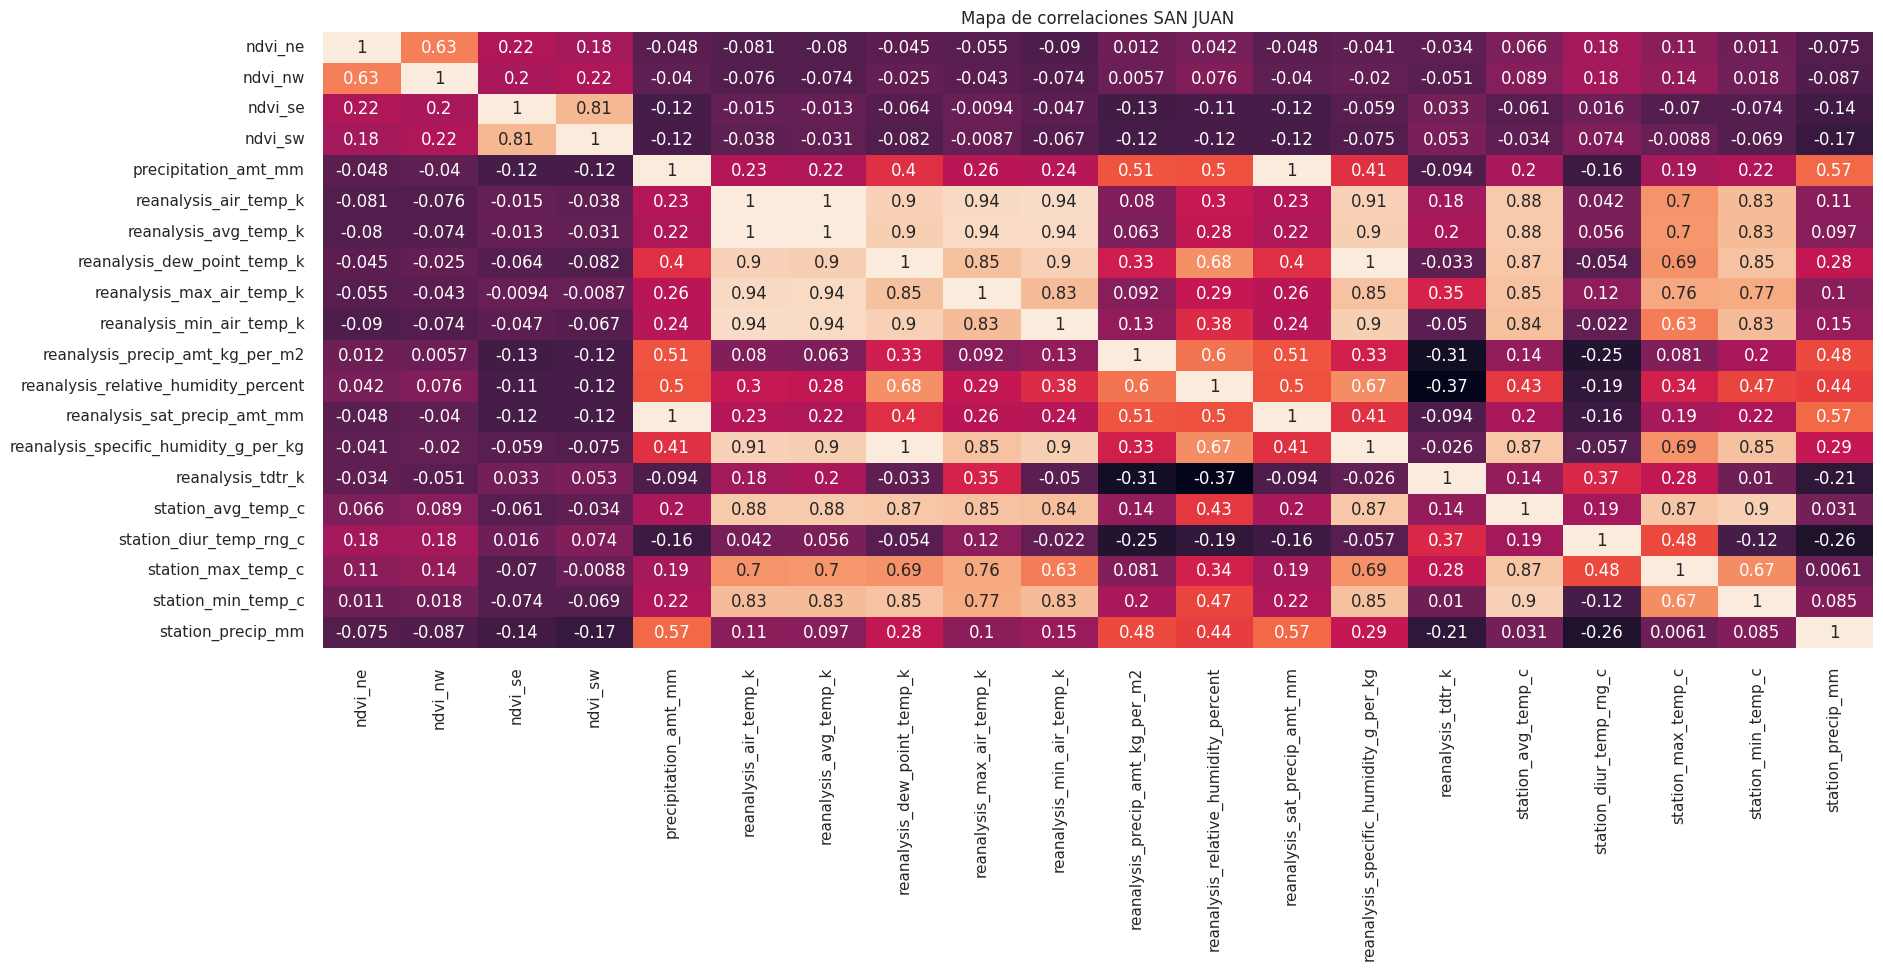

In [77]:
# Mapa de calor para revisar correlaciones entre variables SAN JUAN:

corr = sj_train.corr(numeric_only=True)
sbrn.set(rc = {'figure.figsize':(20,8)})
heatmap = sbrn.heatmap(corr, annot = True, cbar = False)
plt.title('Mapa de correlaciones SAN JUAN')

Text(0.5, 1.0, 'Mapa de correlaciones IQUITOS')

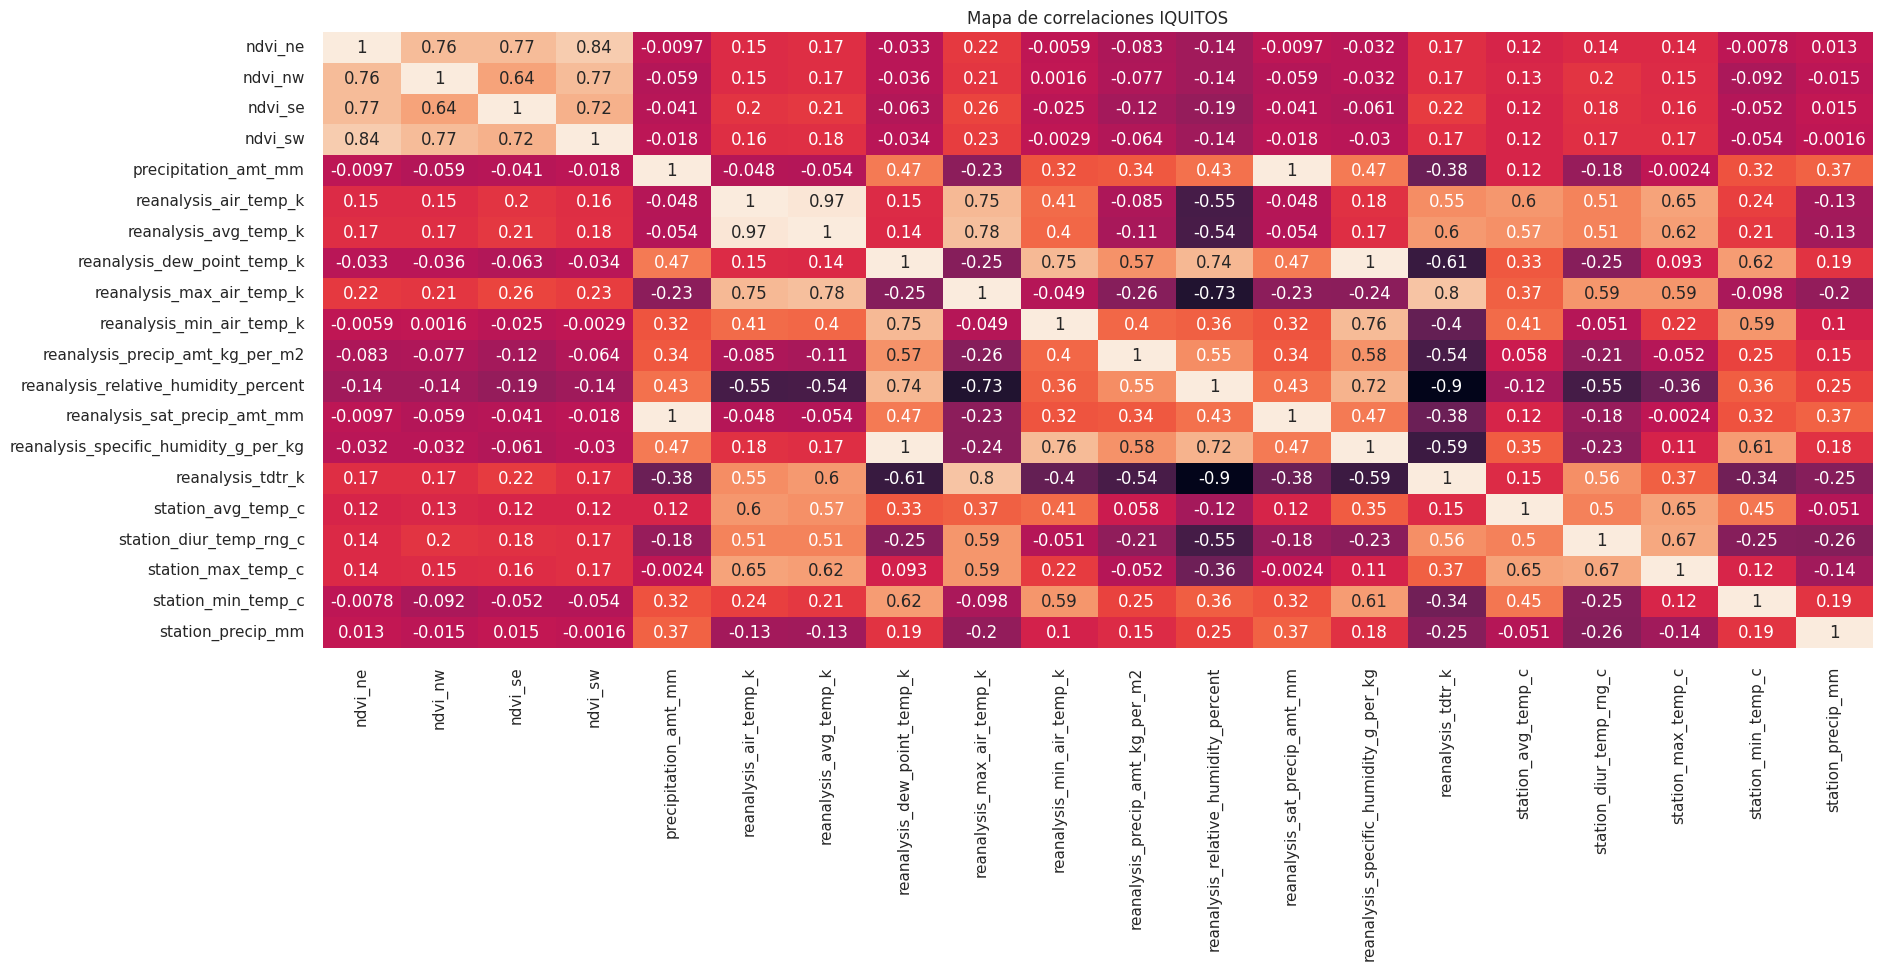

In [78]:
# Mapa de calor para revisar correlaciones entre variables IQUITOS:

corr = iq_train.corr(numeric_only=True)
sbrn.set(rc = {'figure.figsize':(20,8)})
heatmap = sbrn.heatmap(corr, annot = True, cbar = False)
plt.title('Mapa de correlaciones IQUITOS')

A partir de los mapas de calor se puede observar que hay dos parejas de variables que tienen una correlación del 100%:

1.   reanalysis_sat_precip_amt_mm = precipitation_amt_mm 
2.   reanalysis_dew_point_temp_k = reanalysis_specific_humidity_g_per_kg

Tener variables con una correlación del 100% hace que sean redundantes, por lo tanto se decide eliminar 2 variables del dataframe. Los mapas de calor muestran que hay otras variables altamente correlacionadas, específicamente las que describen la temperatura de San José en grados kelvin, sin embargo, se decide mantener estas variables ya que en el momento no se cuenta con conocimiento sobre cual tendrá mejores cualidades descriptivas para predecir el número total de casos de dengue.




In [79]:
# Basado en las descripciones de los datos se eliminan "precipitation_amt_mm"  y "reanalysis_specific_humidity_g_per_kg"

sj_train.drop(["precipitation_amt_mm", "reanalysis_specific_humidity_g_per_kg"], axis = 1, inplace = True)
iq_train.drop(["precipitation_amt_mm", "reanalysis_specific_humidity_g_per_kg"], axis = 1, inplace = True)

In [80]:
# valores númericos del df para clusterizar

sj_numeric_val = sj_train.iloc[:, 2:]
iq_numeric_val = iq_train.iloc[:, 2:]

# Valores numéricos escalados para clusterizar

scaler = MinMaxScaler()
sj_scaled_nv = scaler.fit_transform(sj_numeric_val)
iq_scaled_nv = scaler.fit_transform(iq_numeric_val)

Se aplica un filto a los dataframes de ambas ciudades utilizando la función pandas.iloc(). Este filtro cumple la función de excluir las variables no numéricas y permite aplicar funciones de normalización y clusterización sobre el dataframe.

Después de tener las variables filtradas, los dataframes son normalizados utilizando el MinMaxScaler() de la librería sklearn. Esta normalización permite realizar clusterización tanto con los datos crudos como con los datos normalizados y analizar las diferencias en los resultados obtenidos.

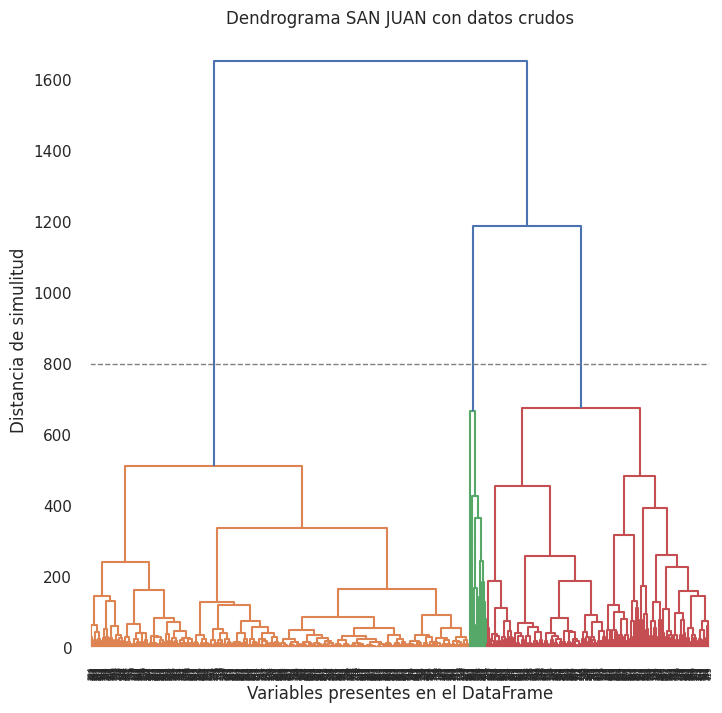

In [81]:
# Dendrograma representando posibles divisiones de los datos para San Juan SIN ESCALAR:

clusters_sj = cluster.hierarchy.linkage(sj_numeric_val, method = "ward")
plt.figure(figsize=(8, 8))
cluster.hierarchy.dendrogram(clusters_sj)
plt.xlabel("Variables presentes en el DataFrame")
plt.ylabel("Distancia de simulitud")
plt.title('Dendrograma SAN JUAN con datos crudos')
plt.axhline(y=800, c='grey', lw=1, linestyle='dashed')
plt.show()

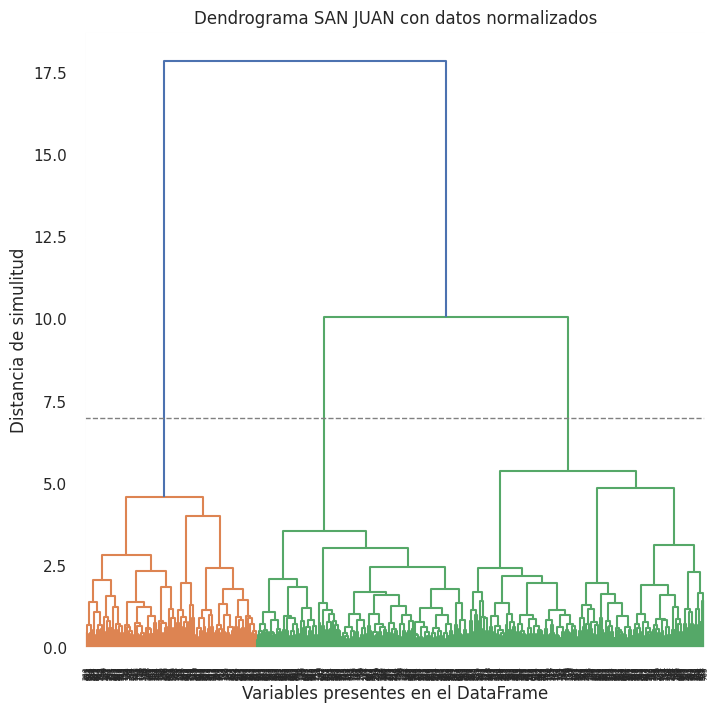

In [82]:
# Dendrograma representando posibles divisiones de los datos para San Juan ESCALADOS:

clusters_sj_scaled = cluster.hierarchy.linkage(sj_scaled_nv, method = "ward")
plt.figure(figsize=(8, 8))
cluster.hierarchy.dendrogram(clusters_sj_scaled)
plt.xlabel("Variables presentes en el DataFrame")
plt.ylabel("Distancia de simulitud")
plt.title('Dendrograma SAN JUAN con datos normalizados')
plt.axhline(y=7, c='grey', lw=1, linestyle='dashed')
plt.show()

Al graficar los dendrogramas de la ciudad de San Juan se observa que las variables podrían ser divididas en 3 clusters; esta división se evidencia con mayor claridad en el dendrograma realizado sobre datos normalizados. Para este caso si se hace una linea de corte en y=7 se genera una división en 3 clusters que, a simple vista parecen contar con una cantidad de datos similar.

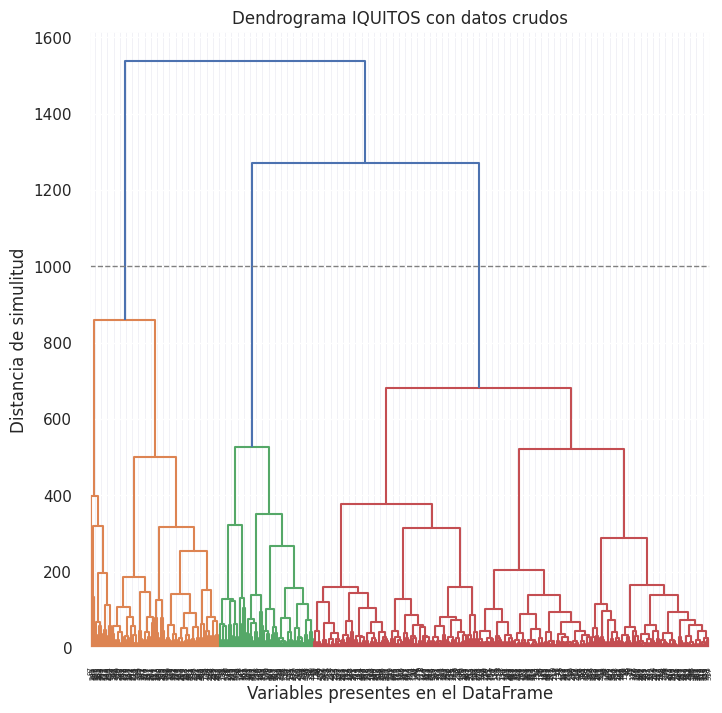

In [83]:
# Dendrograma representando posibles divisiones de los datos para Iquitos SIN ESCALAR

clusters_iq = cluster.hierarchy.linkage(iq_numeric_val, method = "ward")
plt.figure(figsize=(8, 8))
cluster.hierarchy.dendrogram(clusters_iq)
plt.title('Dendrograma IQUITOS con datos crudos')
plt.xlabel("Variables presentes en el DataFrame")
plt.ylabel("Distancia de simulitud")
plt.title('Dendrograma IQUITOS con datos crudos')
plt.axhline(y=1000, c='grey', lw=1, linestyle='dashed')
plt.show()

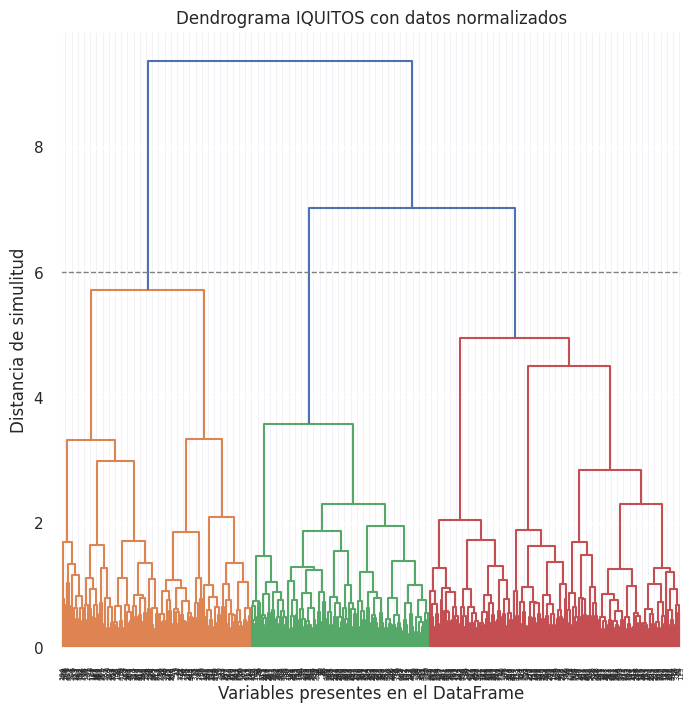

In [84]:
# Dendrograma representando posibles divisiones de los datos para Iquitos ESCALADO

clusters_iq_scaled = cluster.hierarchy.linkage(iq_scaled_nv, method = "ward")
plt.figure(figsize=(8, 8))
cluster.hierarchy.dendrogram(clusters_iq_scaled)
plt.title('Dendrograma IQUITOS con datos normalizados')
plt.xlabel("Variables presentes en el DataFrame")
plt.ylabel("Distancia de simulitud")
plt.title('Dendrograma IQUITOS con datos normalizados')
plt.axhline(y=6, c='grey', lw=1, linestyle='dashed')
plt.show()

En el dendrograma de la ciudad de Iquitos se puede observar una distribución diferente de las variables, ya que a pesar de que trazando una linea de corte en y=6 también se genera una división en 3 grupos de datos, tanto los datos del grupo rojo como los del grupo naranja cuantan con lienas verticales que cubren bastante distancia, indicando que los datos dentro de estos clusters no comparten tantas similitudes como los del conjunto de datos de San Juan. Estas diferencias se podrían atribuír al hecho de que la cantidad de datos para Iquitos es menor o a las condiciones climaticas de la ciudad.

In [85]:
# Unir valores numericos para hacer verificaciones sobre datos completos, esto se hace debido a las diferencias de resultados entre IQ y SJ

train_numeric_val = pd.concat([sj_numeric_val, iq_numeric_val])
train_scaled_nv = scaler.fit_transform(train_numeric_val)

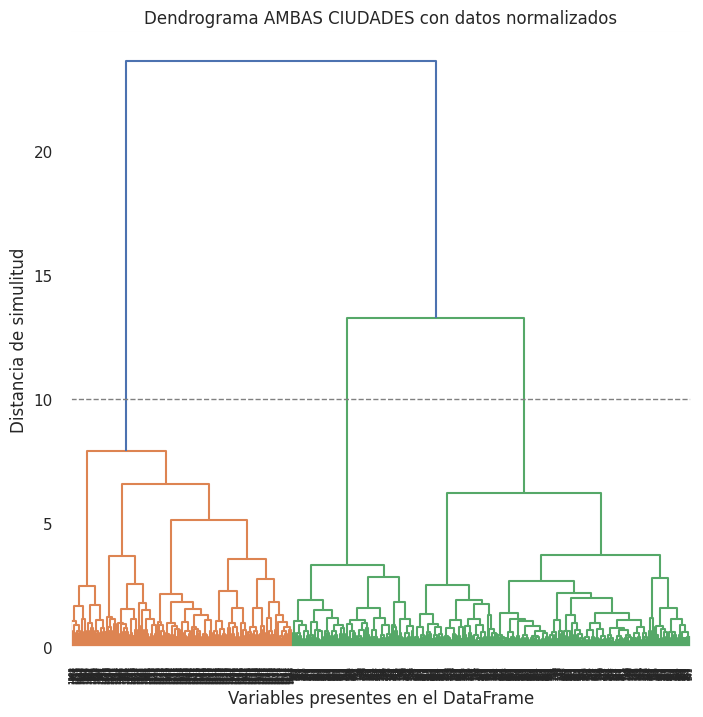

In [86]:
# Dendrograma representando posibles divisiones de los datos de AMBAS CIUDADES ESCALADOS

clusters_train_scaled = cluster.hierarchy.linkage(train_scaled_nv, method = "ward")
plt.figure(figsize=(8, 8))
cluster.hierarchy.dendrogram(clusters_train_scaled)
plt.title('Dendrograma AMBAS CIUDADES con datos normalizados')
plt.xlabel("Variables presentes en el DataFrame")
plt.ylabel("Distancia de simulitud")
plt.axhline(y=10, c='grey', lw=1, linestyle='dashed')
plt.show()

Finalmente se genera un gráfico del dendrograma para el dataset completo (incluyendo ambas ciudades). Este dendrograma presenta una forma similar a la del de San Juan, hecho que tiene sentido ya que los datos de esta ciudad ocupan cerca del 65% del set de datos original.

Implementando una linea de corte en y=10 se obtiene una división en 3 conjuntos de datos claramente diferenciados; esta división no coincide con el análisis realizado con anterioridad en el que se planteaba la división de datos en 4 subconjuntos, pero tampoco son lo suficientemente convincentes por si solos para refutarlas, por lo que se determina que es necesario realizar más pruebas de clusterización con la intencion de corroborar estos resultados iniciales.

In [87]:
# Función para optimizar cluster usando gráfico de codo, recuperado de: https://youtu.be/iNlZ3IU5Ffw

def optimize_k_means(data, max_k, name):
  means = []
  inertias = []
  silouhettes = []

  for k in range(1, max_k):
    k_means = KMeans(n_clusters = k, n_init=10)
    k_means.fit(data)
    clustering = k_means.fit_predict(data)
    means.append(k)
    inertias.append(k_means.inertia_)

  knee_point = KneeLocator(means, inertias, S=1.0, curve="convex", direction="decreasing")
  knee_point.plot_knee(figsize=(12,8))
  plt.title('Gráfico de codo '+ name)
  plt.xlabel("Número de clusters")
  plt.ylabel("Inercia")
  plt.grid(True)
  plt.show()

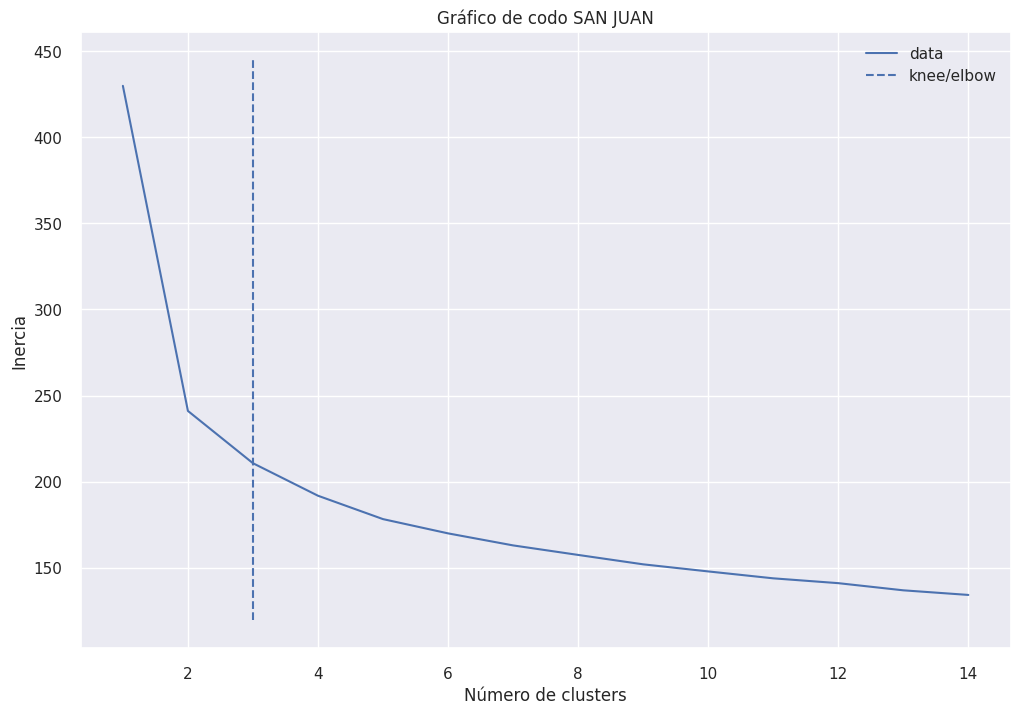

In [88]:
# Ejecución de la función para mostrar gráfico de codo SAN JUAN

optimize_k_means(sj_scaled_nv, 15, name="SAN JUAN")

Al implementar el gráfico de codo para el set de datos de la ciudad de San Juan se puede observar que el número de clusters en donde la función tiene un punto de codo o se empieza a ver una reducción en las beneficios de la división es con un total de 3 clusters. Estos resultados coinciden con los observados en el dendrograma generado para esta ciudad.

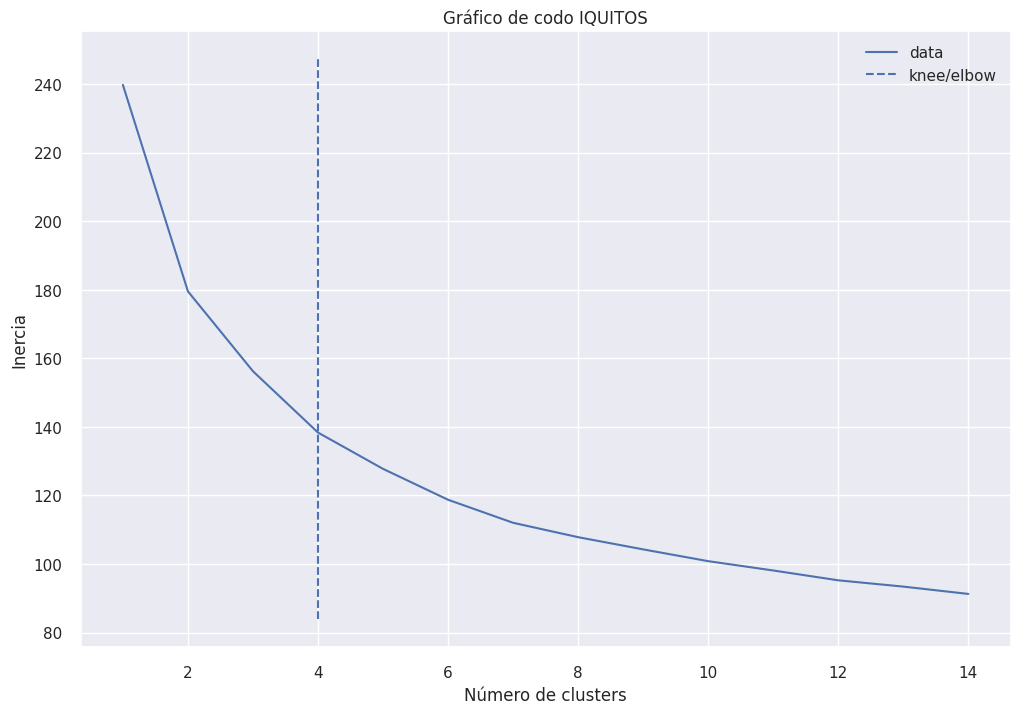

In [89]:
# Ejecución de la función para mostrar gráfico de codo IQUITOS

optimize_k_means(iq_scaled_nv, 15, name="IQUITOS")

El gráfico de codo para el set de datos de la ciudad de Iquitos indica un número ideal de clusters igual a 4. Al analizar el dendrograma para la ciudad de Iquitos se menciona la posibilidad de dividir sus datos en 3 o 4 clusters, ya que una de las divisiones (color naranja) muestra una distancia vertical considerable entre dos subconjuntos.

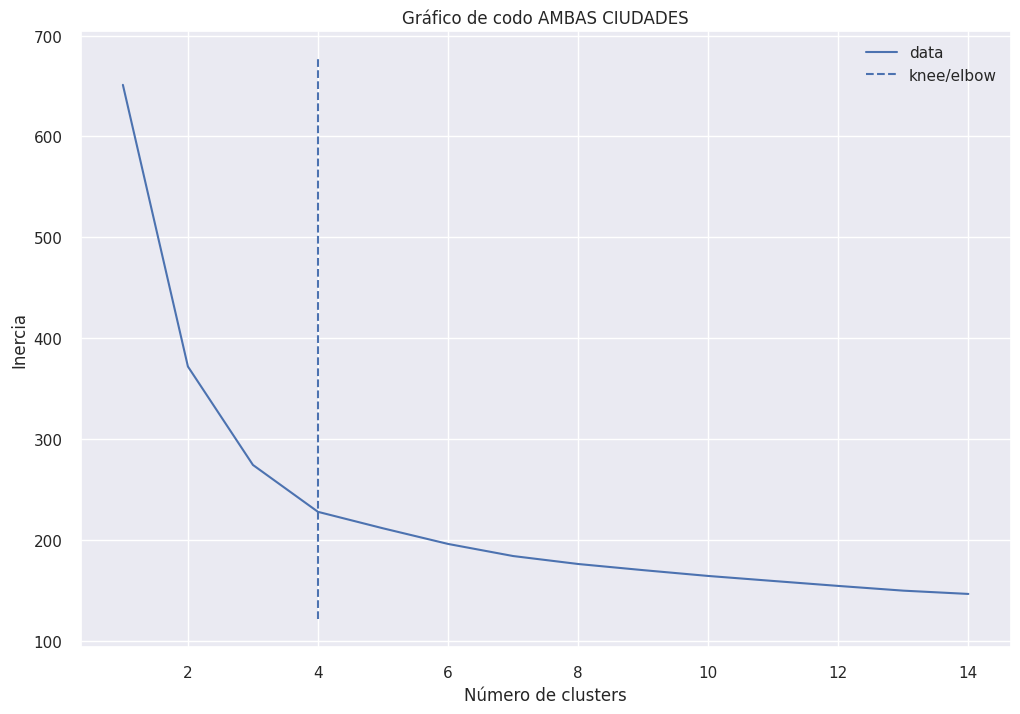

In [90]:
# Ejecución de la función para mostrar gráfico de codo AMBAS CIUDADES

optimize_k_means(train_scaled_nv, 15, name="AMBAS CIUDADES")

Tras implementar la función para gráficos de codo en ambas ciudades, el número ideal de clusters indicados en igual a 4. Esta cantidad de clusters no coincide con los observados en el dendrograma, que presenta una división clara en 3 conjuntos de datos.

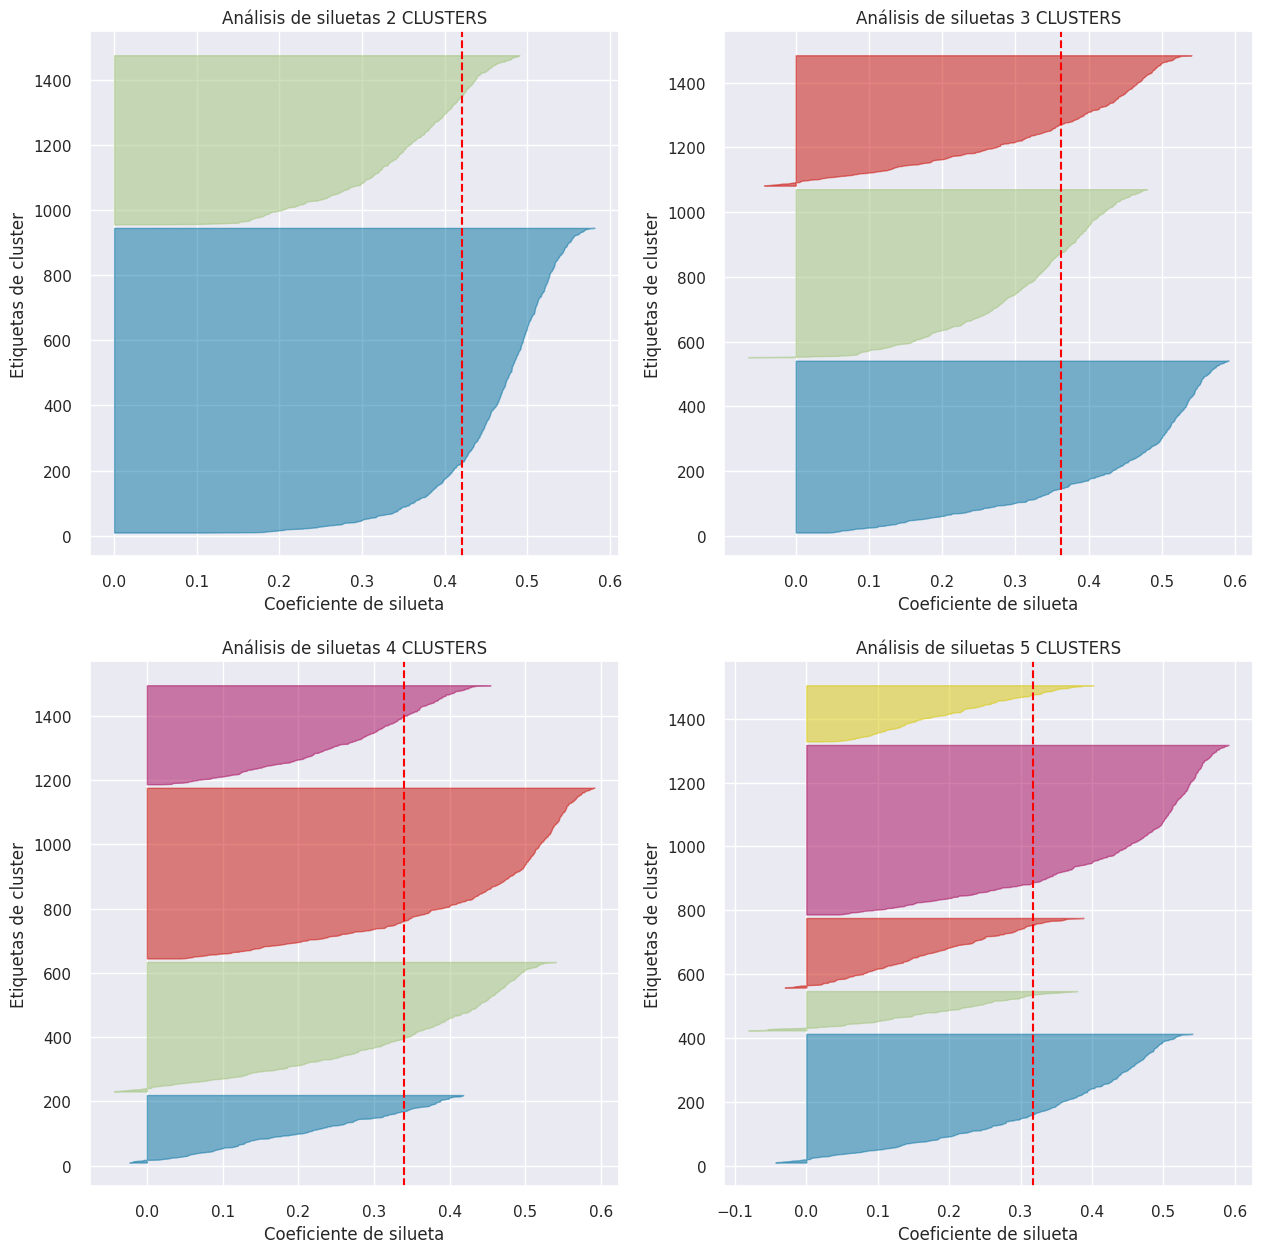

In [115]:
# Generación de "Silhouette plots" para 2, 3, 4 y 5 clusters AMBAS CIUDADES:
# Recuperado de: https://vitalflux.com/kmeans-silhouette-score-explained-with-python-example/

fig, ax = plt.subplots(2, 2, figsize=(15, 15))

ax1 = ax[0, 0]
ax1.set_title("Análisis de siluetas 2 CLUSTERS")
ax1.set_ylabel("Etiquetas de cluster")
ax1.set_xlabel("Coeficiente de silueta")

ax1 = ax[0, 1]
ax1.set_title("Análisis de siluetas 3 CLUSTERS")
ax1.set_ylabel("Etiquetas de cluster")
ax1.set_xlabel("Coeficiente de silueta")

ax1 = ax[1, 0]
ax1.set_title("Análisis de siluetas 4 CLUSTERS")
ax1.set_ylabel("Etiquetas de cluster")
ax1.set_xlabel("Coeficiente de silueta")

ax1 = ax[1, 1]
ax1.set_title("Análisis de siluetas 5 CLUSTERS")
ax1.set_ylabel("Etiquetas de cluster")
ax1.set_xlabel("Coeficiente de silueta")

for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=970120)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(train_scaled_nv)

Ya que los resultados de número de clusters obtenidos por dendrograma y gráfico de codo para el conjunto de datos de ambas ciudades no coinciden en el mismo número de clusters (3 para dendrograma y 4 para gráfico de codo), se implementa un análisis de siluetas sobre los datos con la intención de corroborar alguno de estos valores.

El gráfico de siluetas que presenta la distribución más uniforme entre los clusters y un coeficiente promedio mayor (indicado por la linea roja) es el realizado con 3 clusters. Por lo tanto, se da mayor peso a la posibilidad de dvidir el set de datos de ambas ciudades en 3 cluster, al estar respaldado por 2 de los análisis realizados.

Ya que se cuenta con una cantidad tentativa de clusters para cada uno de los dataframes analizados (San Juan, Iquitos y Ambas ciudades), se grafican clustermaps con el objetivo de indicar posiblesrelaciones y agrupaciones entre los datos presentes en el dataframe. A continuación se presentan algunos de los resultados observados en estos clustermap.

Text(0.5, 1.0, 'Clustermap SAN JUAN')

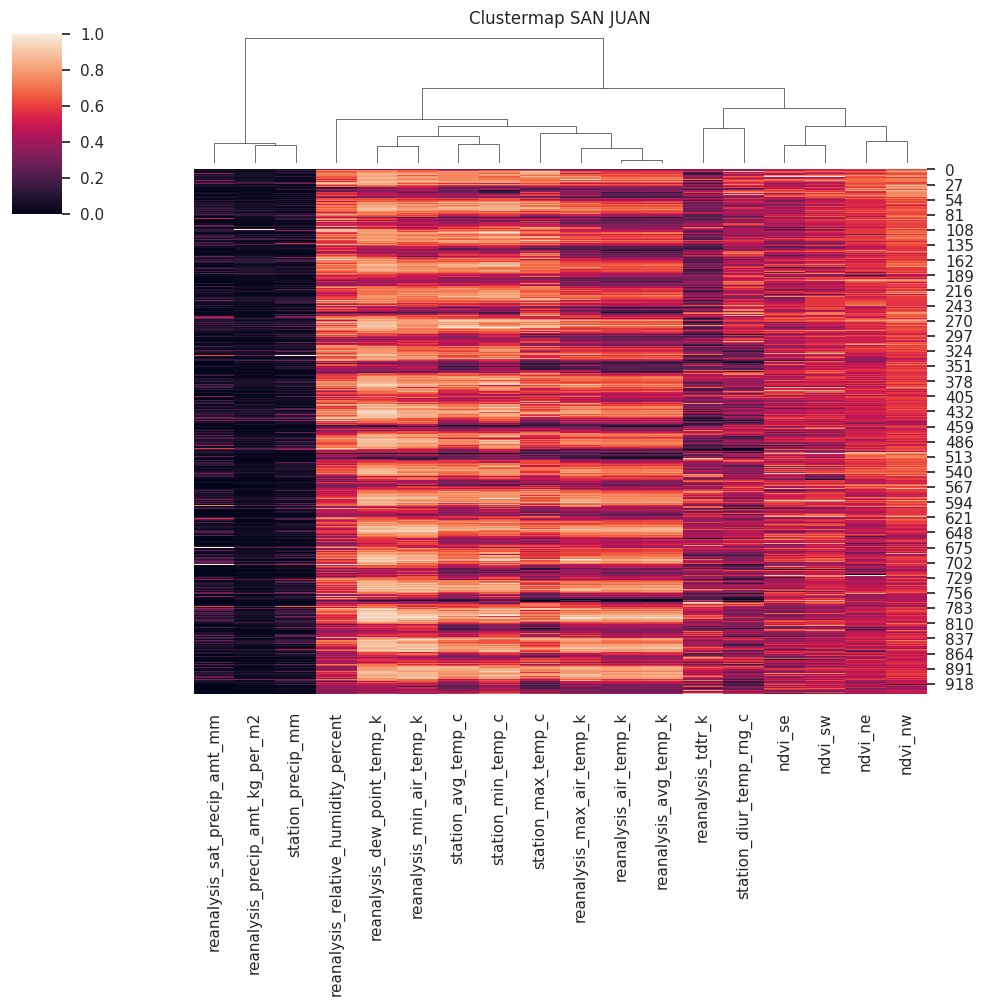

In [140]:
# Clustermap SAN JUAN NORMALIZADO

sbrn.set(color_codes = True)
clus_map = sbrn.clustermap(sj_numeric_val, standard_scale=1, row_cluster=False, method="complete")
clus_map.ax_col_dendrogram.set_title('Clustermap SAN JUAN')

El número ideal de clusters indicado previamente para el conjunto de datos de San Juan es igual a 3; este número coincide con lo observado en la gráfica, en donde se ve una división clara en tres tipos de datos (Precipitación, temperatura y niveles de vegetación), sin embargo vale la pena resaltar que 2 variables referentes a la temperatura (reanalysis_tdtr_k y station_diur_temp_rng_c) quedaron agrupadas con los valores de nivel de vegetación y que la variable de reanalysis_relative_humidity_percent fué agrupada con las temperaturas a pesar de ser una variable que mide humedad y de tener valores mas alejados que las otras variables de este conjunto, evidenciado por la altura de su línea vertical en el dendrograma.

Text(0.5, 1.0, 'Clustermap IQUITOS')

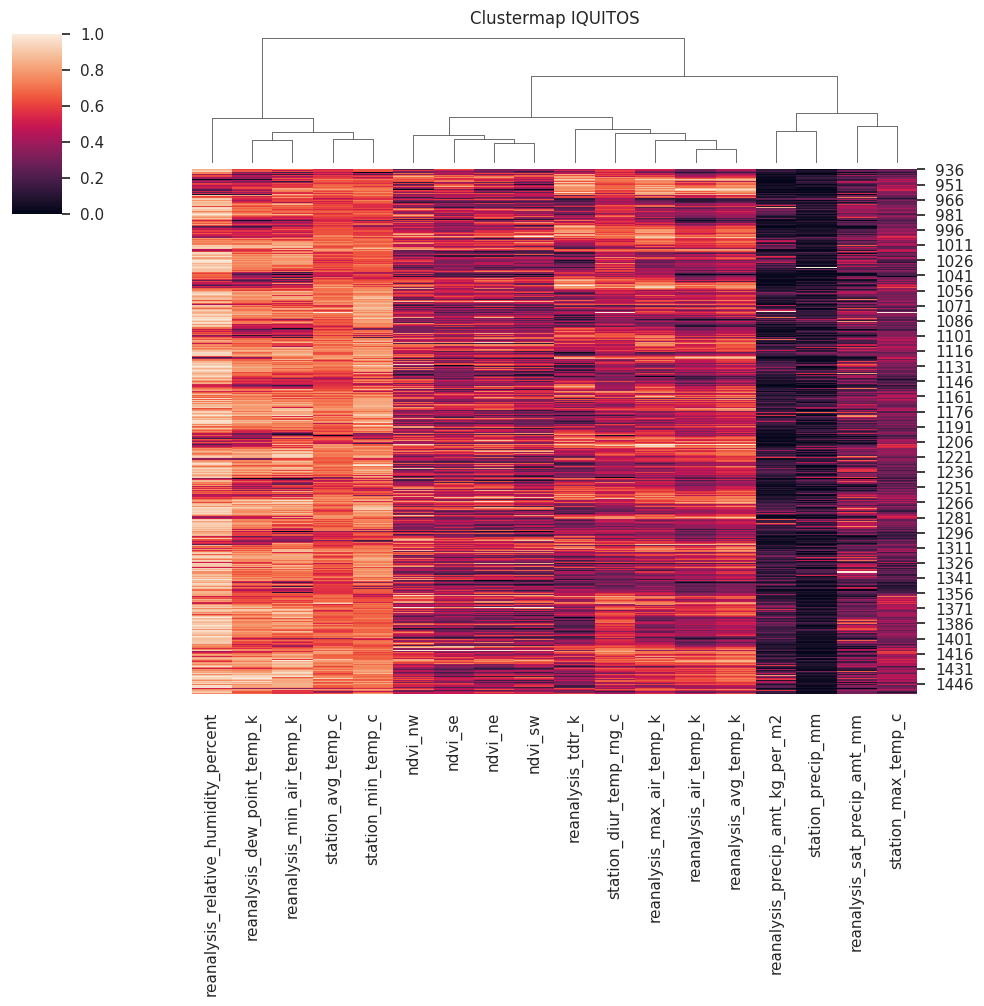

In [141]:
# Clustermap IQUITOS NORMALIZADO

sbrn.set(color_codes = True)
clus_map = sbrn.clustermap(iq_numeric_val, standard_scale=1, row_cluster=False, method="complete")
clus_map.ax_col_dendrogram.set_title('Clustermap IQUITOS')

El número ideal de clusters indicado previamente para el conjunto de datos de Iquitos es igual a 4; este número no coincide con lo observado en el gráfico de clustermap, en el cual se evidencia una división en 3 subconjuntos de datos. Para este set de datos los valores referentes a temperaturas no fueron tan biene agrupados, ya que se encuentran divididos en tres subconjuntos diferentes. De nuevo se puede observar que los valores de reanalysis_relative_humidity_percent presentan diferencias considerables incluso con las variables presentas en su subgrupo, mientras que los clusters que hacen referencia a variables de vegetación y precipitaciones en la ciudad fueron capturados correctamente.

Text(0.5, 1.0, 'Clustermap AMBAS CIUDADES')

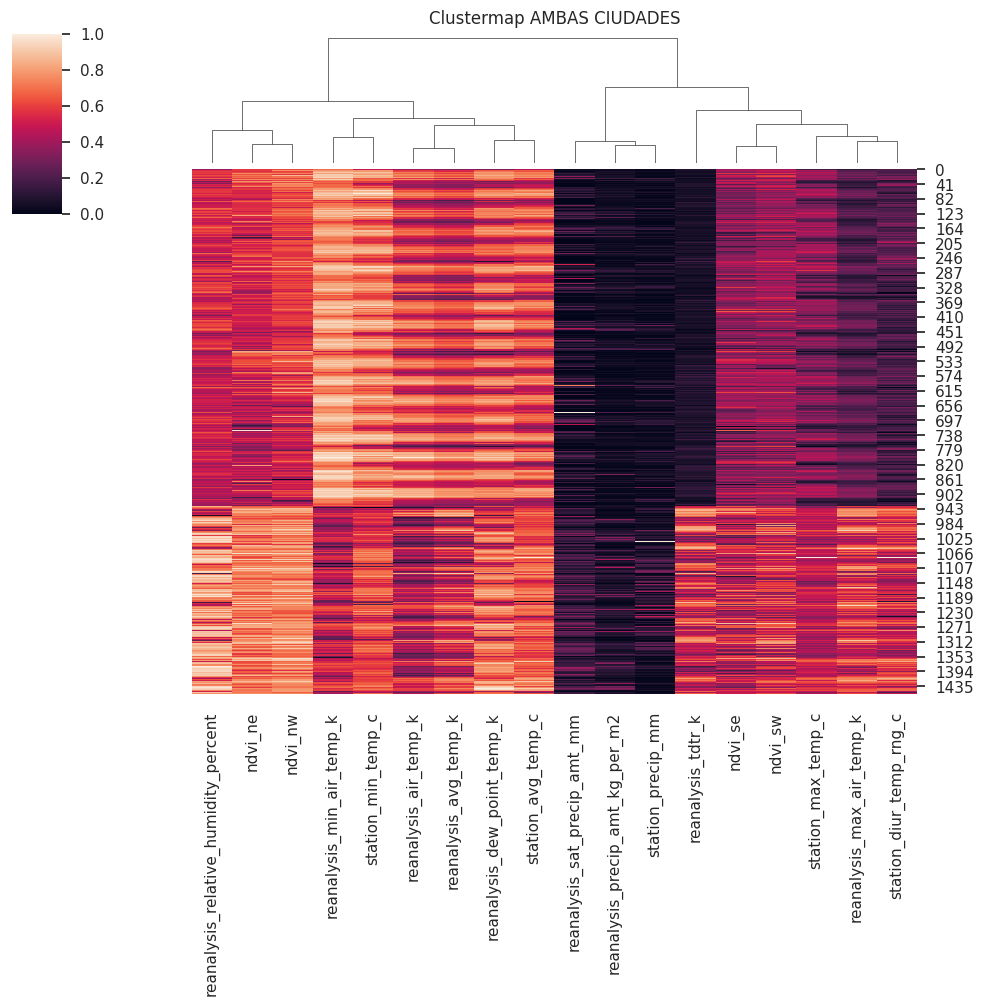

In [142]:
# Clustermap AMBAS CIUDADES NORMALIZADO

sbrn.set(color_codes = True)
clus_map = sbrn.clustermap(train_numeric_val, standard_scale=1, row_cluster=False, method="complete")
clus_map.ax_col_dendrogram.set_title('Clustermap AMBAS CIUDADES')

Al graficar el clustermap de ambas ciudades se puede evidenciar una agrupación en 4 subconjuntos de datos, sin embargo las divisiones de estos subconjuntos separan datos que describen la misma variable como los valores de ndvi y presentan una clara diferencia en la similitud de datos como los que describen rangos diarios de temperatura cuando el dataset alcanca los valores relacionados con iquitos.

A partir de estos resultados se confirma la necesidad de tratar los datasets de ambas ciudades de manera diferenciada.

Teniendo las conclusiones obtenidas sobre las posibles opciones de clusterización más adecuadas, se pasa a una selección de variables utilizando PCA. Las siguientes celdas ilustran los resultados obtenidos gracias a este análisis.

In [95]:
# Transposición de df para poder ejecutar PCA

transposed_df = pd.DataFrame.transpose(train_numeric_val)
norm_trans_df = scaler.fit_transform(transposed_df)
print(transposed_df.shape)

(18, 1456)


Ratio de variabilidad:  [0.98294445 0.00978846]



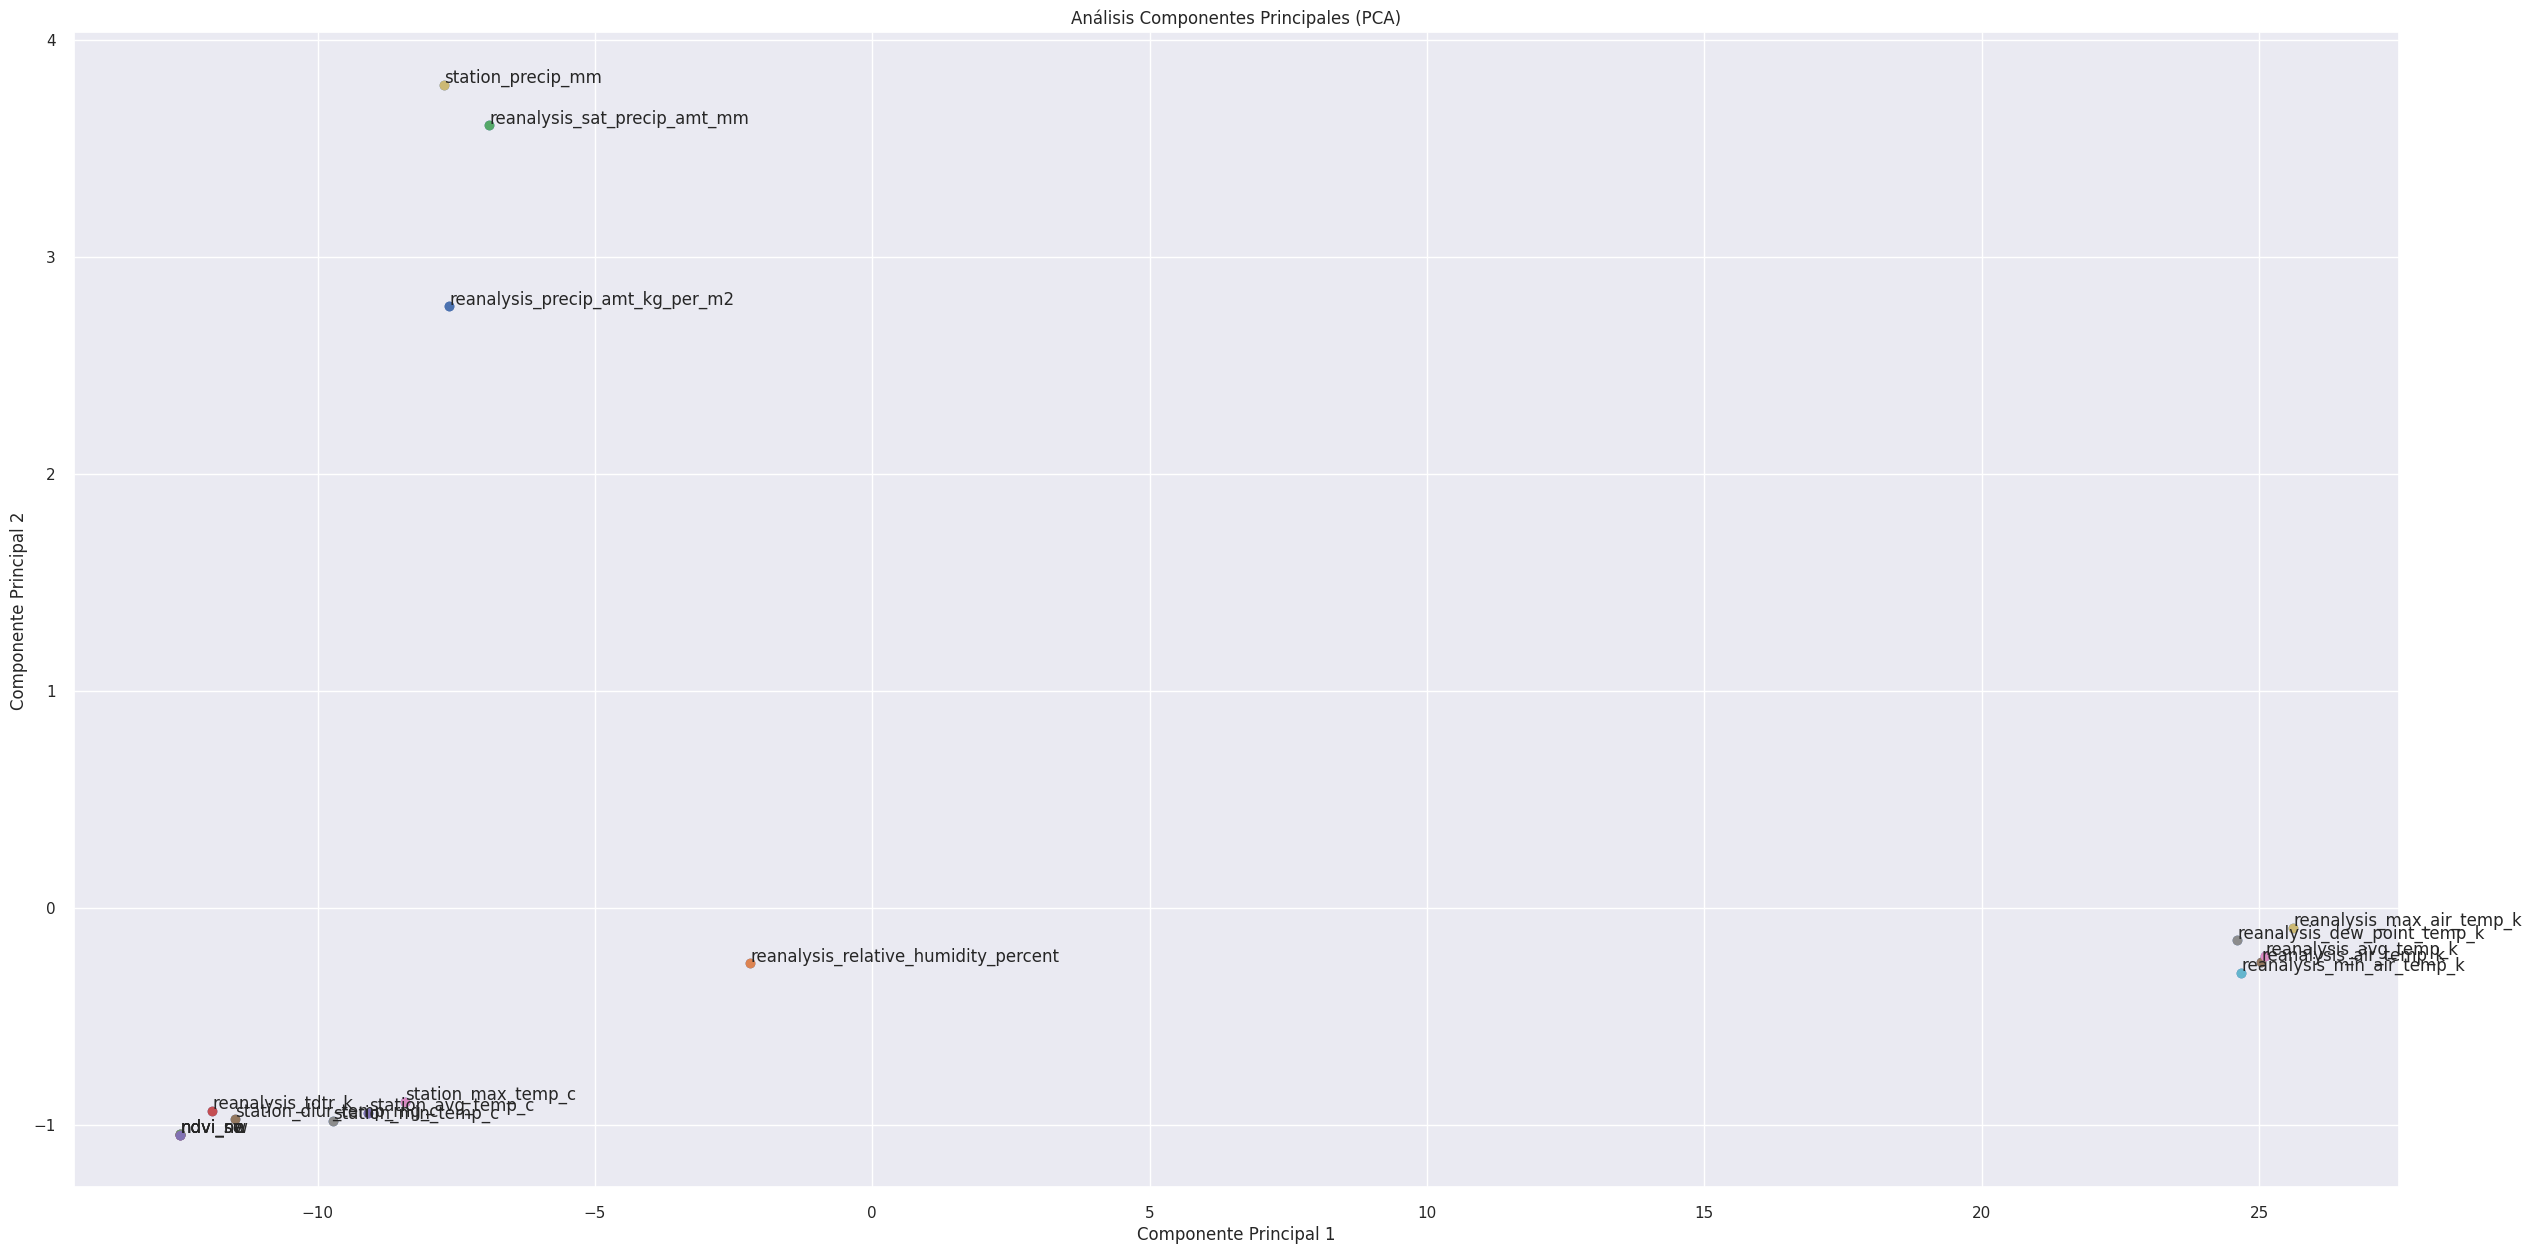

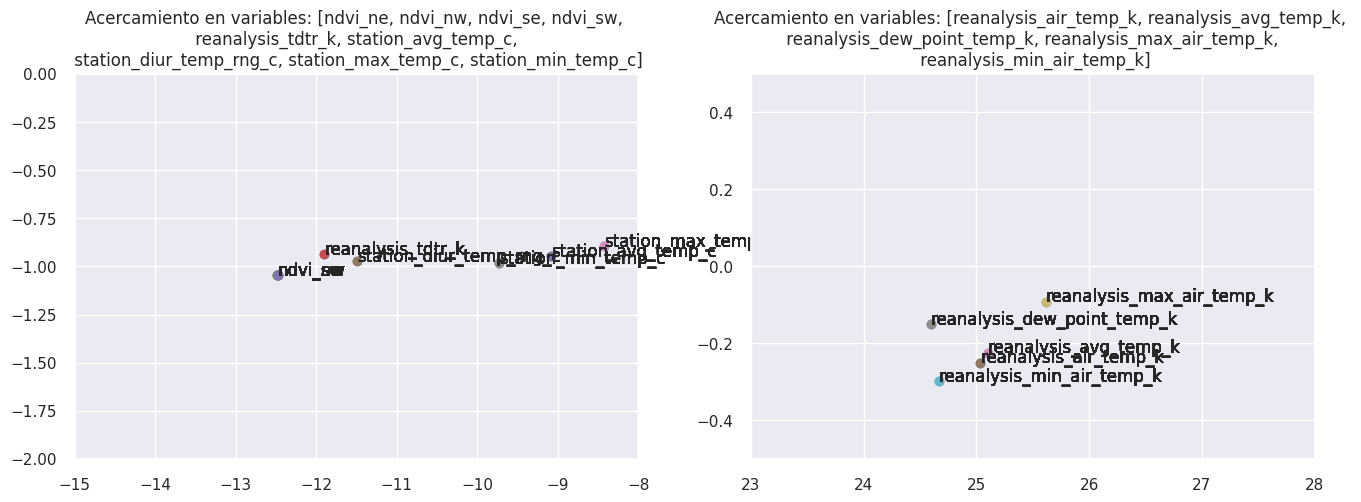

In [118]:
# Ejecución y gráfico de PCA, recuperado de: https://stackoverflow.com/questions/45333733/plotting-pca-output-in-scatter-plot-whilst-colouring-according-to-to-label-pytho

estimator = PCA(n_components = 2)
features_pca = estimator.fit_transform(norm_trans_df)
tags = list(transposed_df.index)
colors = np.random.rand(0, len(tags))
print("Ratio de variabilidad: ", estimator.explained_variance_ratio_)
print("")

plt.figure(figsize=(30, 15))
plt.scatter(features_pca[:,0], features_pca[:,1])
plt.title("Análisis Componentes Principales (PCA)")
plt.ylabel("Componente Principal 2")
plt.xlabel("Componente Principal 1")

for name in tags:
    i = tags.index(name)
    labelpad = 0.01
    plt.text(features_pca[i,0]+labelpad, features_pca[i,1]+labelpad, name, fontsize=12)
    plt.scatter(features_pca[i,0], features_pca[i,1])

fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].scatter(features_pca[:,0], features_pca[:,1])
ax1 = axs[0]
for name in tags:
    i = tags.index(name)
    ax1.scatter(features_pca[i,0], features_pca[i,1])
    for j, txt in enumerate(tags):
        if -15 < features_pca[j, 0] < -8 and -2 < features_pca[j, 1] < 0:
            ax1.annotate(txt, (features_pca[j, 0], features_pca[j, 1]))
            # print(txt)

axs[0].set_title("Acercamiento en variables: [ndvi_ne, ndvi_nw, ndvi_se, ndvi_sw, \n reanalysis_tdtr_k, station_avg_temp_c, \n station_diur_temp_rng_c, station_max_temp_c, station_min_temp_c]")
ax1.set_xlim(-15, -8)
ax1.set_ylim(-2, 0)

axs[1].scatter(features_pca[:,0], features_pca[:,1])
ax2 = axs[1]
for name in tags:
    i = tags.index(name)
    ax2.scatter(features_pca[i,0], features_pca[i,1])
    for j, txt in enumerate(tags):
        if 23 < features_pca[j, 0] < 28 and -0.5 < features_pca[j, 1] < 0.5:
            ax2.annotate(txt, (features_pca[j, 0], features_pca[j, 1]))
            # print(txt)

axs[1].set_title("Acercamiento en variables: [reanalysis_air_temp_k, reanalysis_avg_temp_k, \n reanalysis_dew_point_temp_k, reanalysis_max_air_temp_k, \n reanalysis_min_air_temp_k]")
ax2.set_xlim(23, 28)
ax2.set_ylim(-0.5, 0.5)

plt.show()


A Partir del gráfico de componentes principales, se observa que hay unos grupos de variables con ubicaciones muy cercanas en la tabla, ilustrados con mayor detalle en los acercamientos de la misma. Algunos de estos datos se refieren a un mismo tipo de variable, como las diferentes temperaturas en grados centigrados y kelvin, o los diferentes valores de ndvi, que presentan la mayor cercanía en la gráfica, al estar ubicados prácticamente sobre el mismo punto (x, y).

A partir de lo observado en la gráfica de PCA, se determinan los siguientes pasos a implementar para reducir la cantidad total de variables del dataset mientras se conserva toda la información posible:

In [98]:
# Combinación de variables ndvi SAN JUAN

sj_train["ndvi_north"] = (sj_train["ndvi_ne"] + sj_train["ndvi_nw"])/2
sj_train["ndvi_south"] = (sj_train["ndvi_se"] + sj_train["ndvi_sw"])/2
sj_train.drop(["ndvi_ne", "ndvi_nw", "ndvi_se", "ndvi_sw"], axis = 1, inplace = True)

# Combinación de variables ndvi IQUITOS

iq_train["ndvi_north"] = (iq_train["ndvi_ne"] + iq_train["ndvi_nw"])/2
iq_train["ndvi_south"] = (iq_train["ndvi_se"] + iq_train["ndvi_sw"])/2
iq_train.drop(["ndvi_ne", "ndvi_nw", "ndvi_se", "ndvi_sw"], axis = 1, inplace = True)

Ya que las variables relacionadas con nivel de vegetación (ndvi) tienen ubicaciones tan cercanas en la PCA y están divididas en 4 sectores, se promedian los valores de los sectores norte y sur de cada una. De esta manera se reduce el número total de variables pero se mantienen mas detalles de posibles diferencias entre los dos sectores que si se promediaran todos los valores en un solo valor de ndvi.

In [100]:
# Combinación de variables dew point y relative humidity SAN JUAN

sj_train["air_humidity"] = sj_train["reanalysis_dew_point_temp_k"] + sj_train["reanalysis_relative_humidity_percent"]
sj_train.drop(["reanalysis_dew_point_temp_k", "reanalysis_relative_humidity_percent"], axis = 1, inplace = True)

# Combinación de variables dew point y relative humidity IQUITOS

iq_train["air_humidity"] = iq_train["reanalysis_dew_point_temp_k"] + iq_train["reanalysis_relative_humidity_percent"]
iq_train.drop(["reanalysis_dew_point_temp_k", "reanalysis_relative_humidity_percent"], axis = 1, inplace = True)

La variable de "reanalysis_dew_point_temp_k" describe la humedd especifica medida en cada ciudad, sin embargo al ser medida en grados kelvin está siendo agrupada con los valores que describen temperatura. Por esto se crea una nueva variable llamada "air_humidity" que combina los valores de humedad especifica y relativa en una sola y sirva para representar los valores de humedad den el set de datos de cada ciudad.

In [102]:
# Borrado de variables redundantes: PRECIPITACIÓN

sj_train.drop(["reanalysis_sat_precip_amt_mm", "reanalysis_precip_amt_kg_per_m2"], axis = 1, inplace = True)
iq_train.drop(["reanalysis_sat_precip_amt_mm", "reanalysis_precip_amt_kg_per_m2"], axis = 1, inplace = True)

# Borrado de variables redundantes: TEMPERATURA

sj_train.drop(["reanalysis_air_temp_k", "reanalysis_max_air_temp_k", "reanalysis_min_air_temp_k", "reanalysis_tdtr_k",	"station_avg_temp_c", "station_max_temp_c", "station_min_temp_c"], axis = 1, inplace = True)
iq_train.drop(["reanalysis_air_temp_k", "reanalysis_max_air_temp_k", "reanalysis_min_air_temp_k", "reanalysis_tdtr_k",	"station_avg_temp_c", "station_max_temp_c", "station_min_temp_c"], axis = 1, inplace = True)

Borrado de variables redundantes tanto de precipitaciones como de temperatura basadas en su unicación en el mapa, se trata de conservar las variables que se encuentren más alejadas con el objetivo de mantener toda la variabilidad posible en la PCA de cada ciudad.

In [104]:
# valores númericos de df reducidos para verificar PCA

red_sj_numval = sj_train.iloc[:, 2:]
red_iq_numval = iq_train.iloc[:, 2:]

In [120]:
# Definición de función para gráficar PCA 

def show_pca_graph (df, city_name):
  transposed_df = pd.DataFrame.transpose(df)
  norm_trans_df = scaler.fit_transform(transposed_df)
  print(transposed_df.shape)

  estimator = PCA(n_components = 2)
  features_pca = estimator.fit_transform(transposed_df)
  tags = list(transposed_df.index)
  colors = np.random.rand(0, len(tags))
  print("Ratio de variabilidad: ", estimator.explained_variance_ratio_)
  print("")

  plt.figure(figsize=(30, 15))
  plt.scatter(features_pca[:,0], features_pca[:,1])
  plt.title("Análisis Componentes Principales (PCA) " + city_name)
  plt.ylabel("Componente Principal 2")
  plt.xlabel("Componente Principal 1")

  for name in tags:
      i = tags.index(name)
      labelpad = 0.01
      plt.text(features_pca[i,0]+labelpad, features_pca[i,1]+labelpad, name, fontsize=12)
      plt.scatter(features_pca[i,0], features_pca[i,1])

(7, 936)
Ratio de variabilidad:  [0.99494047 0.00432013]



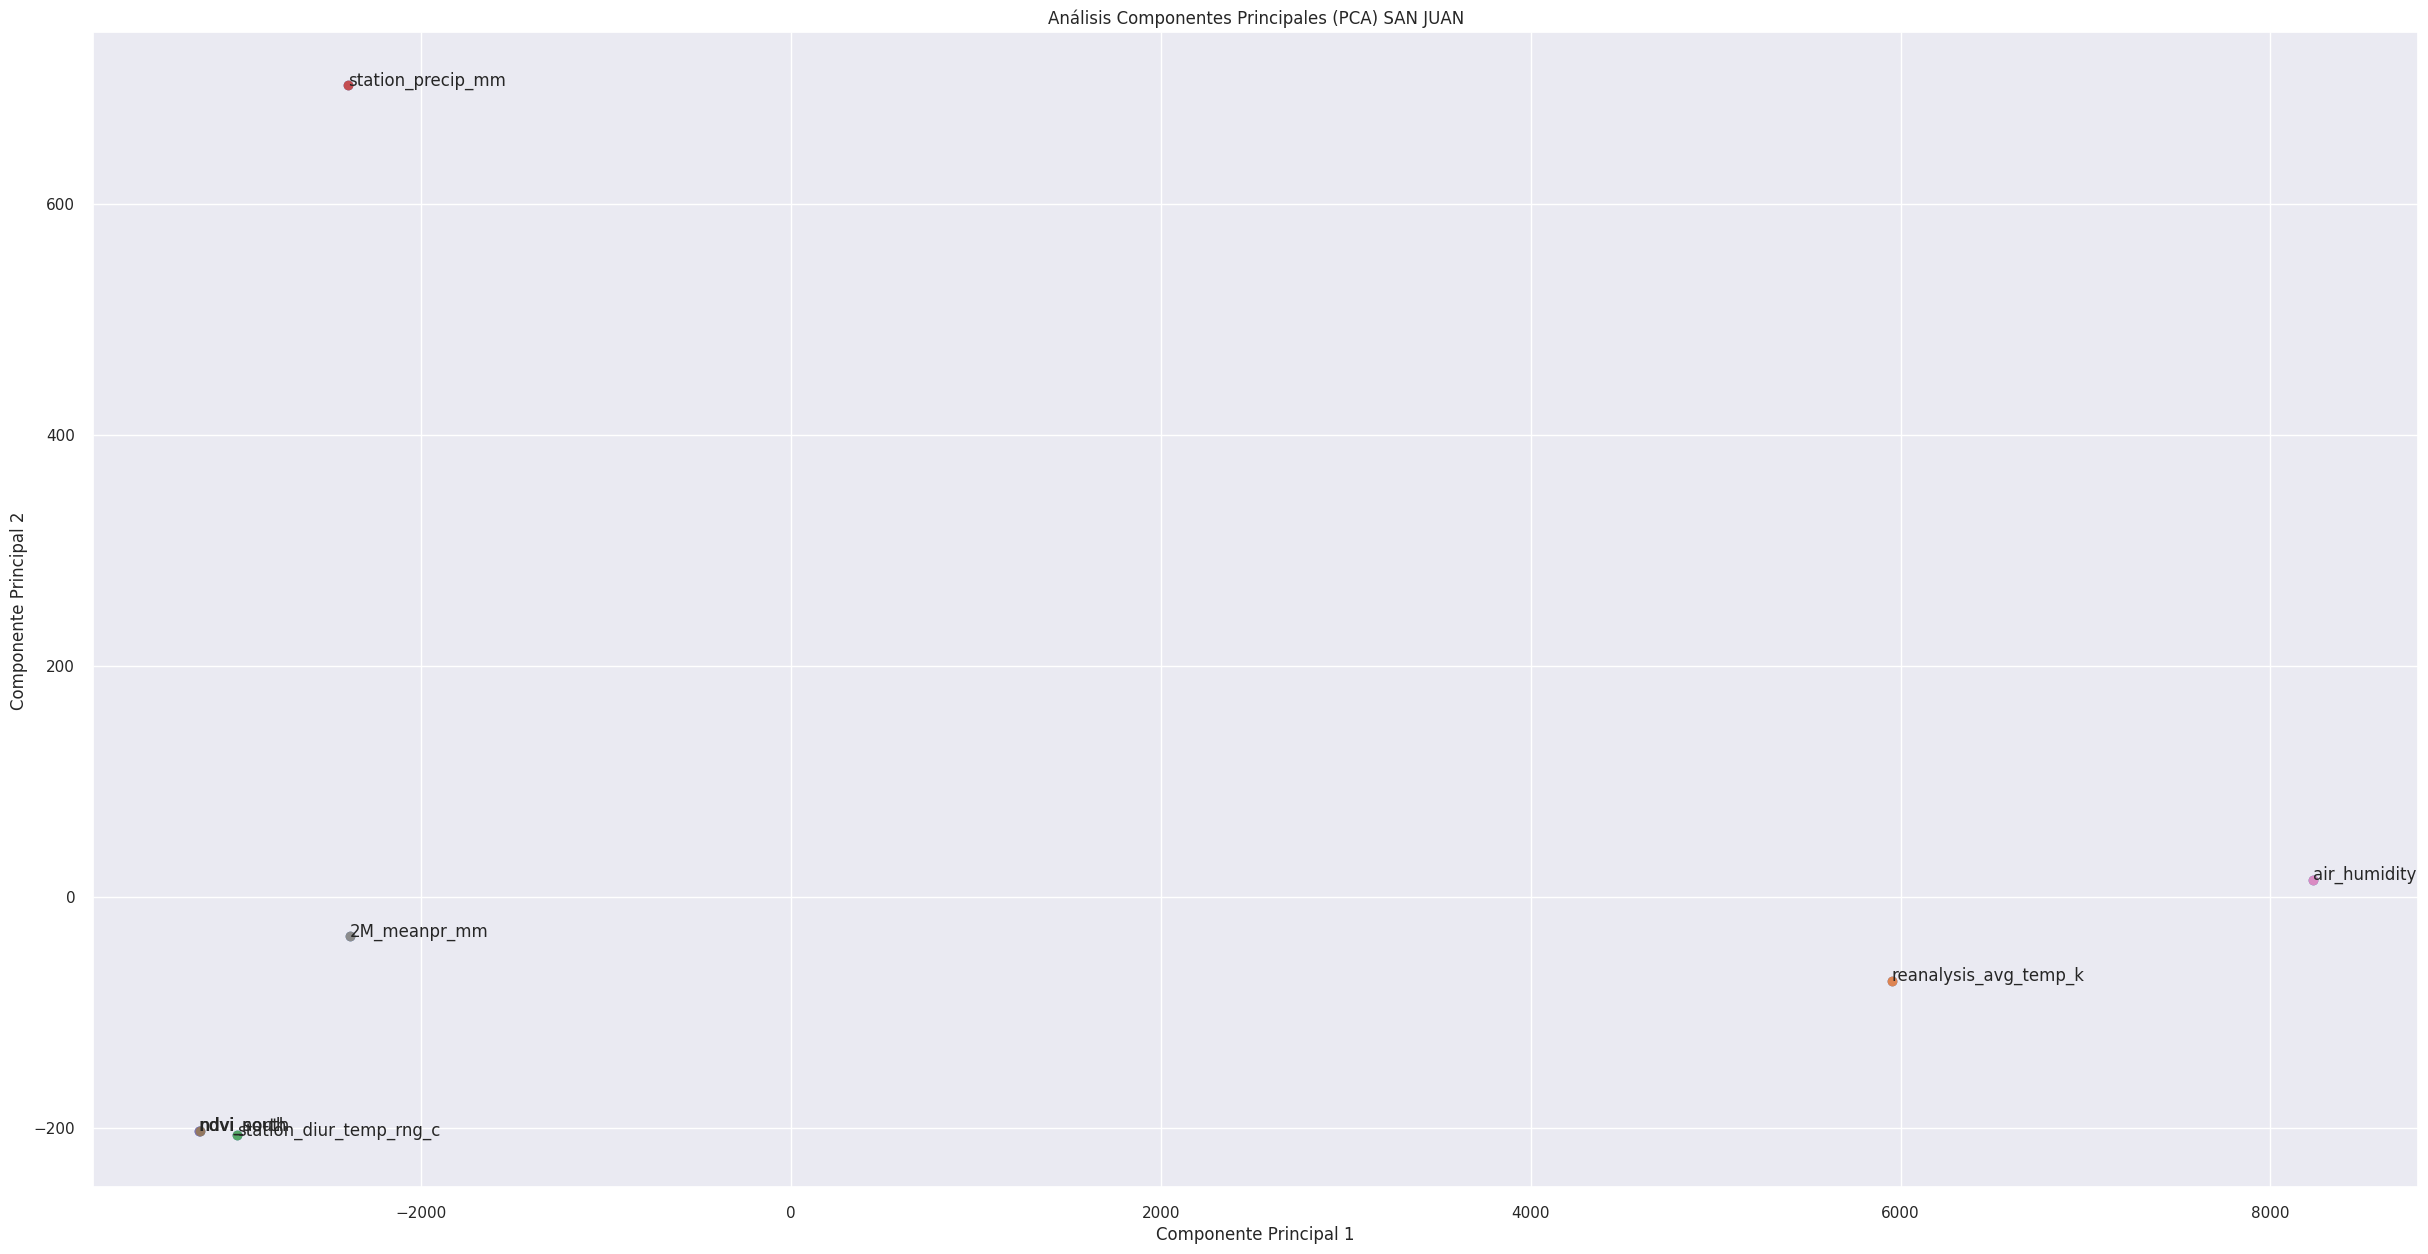

In [121]:
# Gráfico de PCA para nuevo df SAN JUAN:

show_pca_graph(red_sj_numval, city_name = "SAN JUAN")

(7, 520)
Ratio de variabilidad:  [0.97544388 0.02062108]



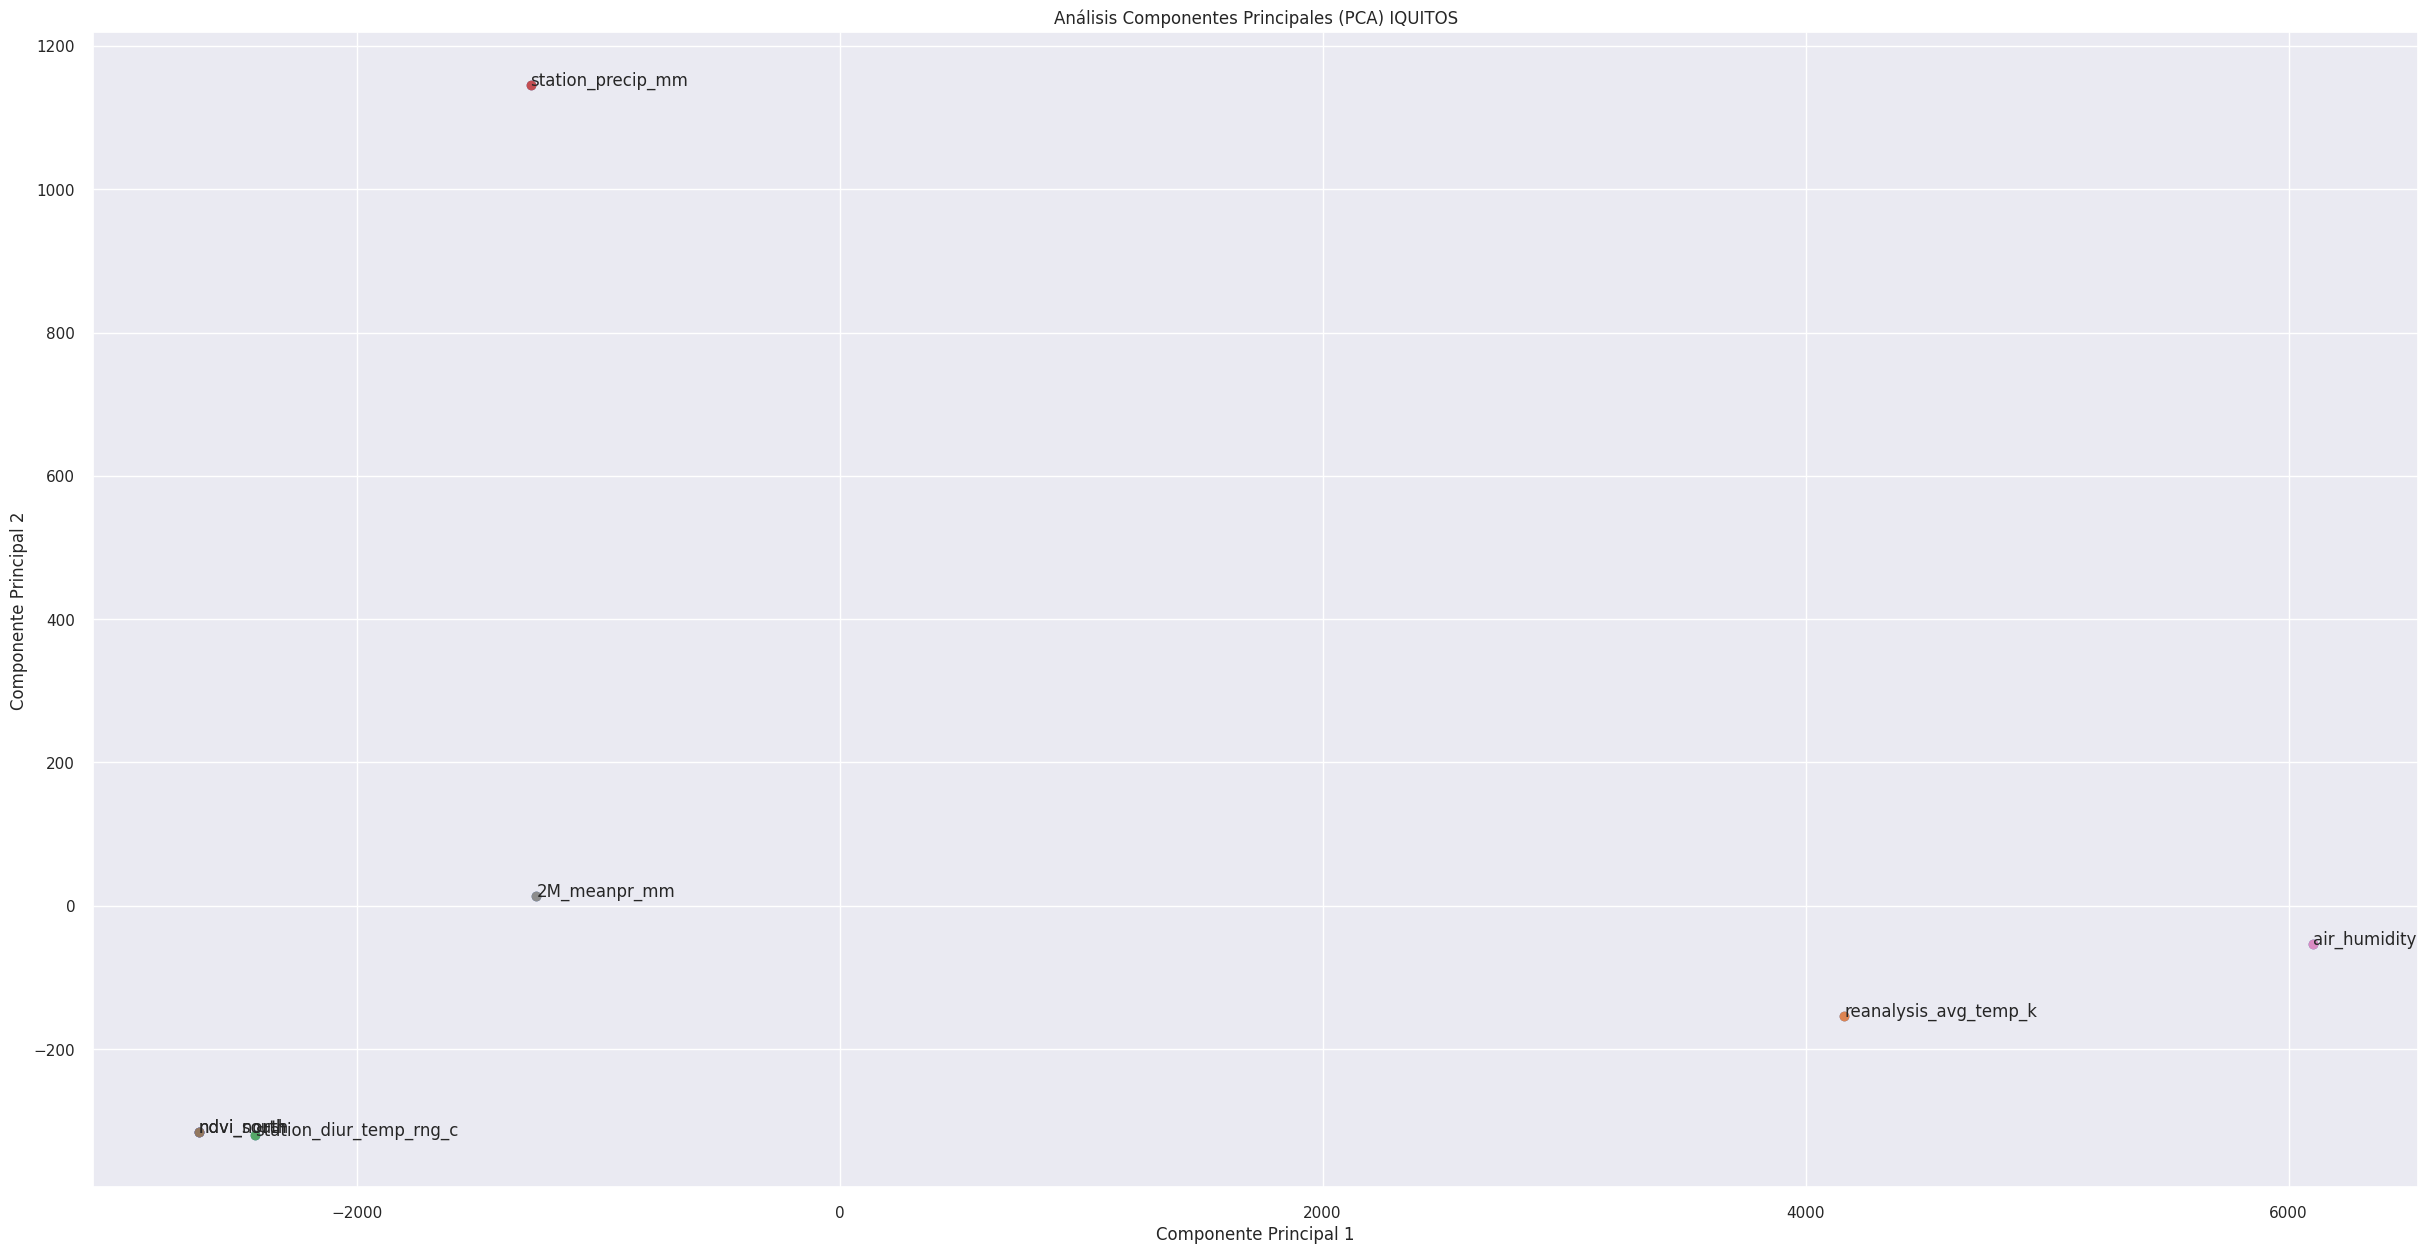

In [122]:
# Gráfico de PCA para nuevo df IQUITOS:

show_pca_graph(red_iq_numval, city_name="IQUITOS")

Al graficar los análisis de PCA de ambas ciudades por separado, se peude evidenciar la conservación en el ratio de variabilidad de ambas a pesar de haber reducido considerablemente la cantidad de evariables a analizar. También se puede visualizar que la distancia entre los componentes no tiene grupos de variables altamente concentrados en un área pequeña.

In [108]:
# Promedios de precipitación últimos 2 meses:

sj_train["2M_meanpr_mm"] = sj_train["station_precip_mm"].rolling(8, min_periods = 1).mean()
iq_train["2M_meanpr_mm"] = iq_train["station_precip_mm"].rolling(8, min_periods = 1).mean()

Ya que los mosquitos que sirven como vector para la enfermedad del dengue dejan sus huevos en aguas estancadas se considera que una variable que tenga en cuenta no solo las precipitaciones de la última semana sino de varias semanas pasadas podría ser útil para predecir en número de casos totales de dengue. 

Para esto se genera un promedio de "rolling" que toma los valores de las últimas 8 semanas y genera un promedio de pluviosidad a partir de estos datos, generando la variable "2M_meanpr_mm".

In [109]:
# valores númericos de df reducidos para verificar ClusterMap

red_sj_numval = sj_train.iloc[:, 2:]
red_iq_numval = iq_train.iloc[:, 2:]

Text(0.5, 1.0, 'Clustermap SAN JUAN Con variables reducidas')

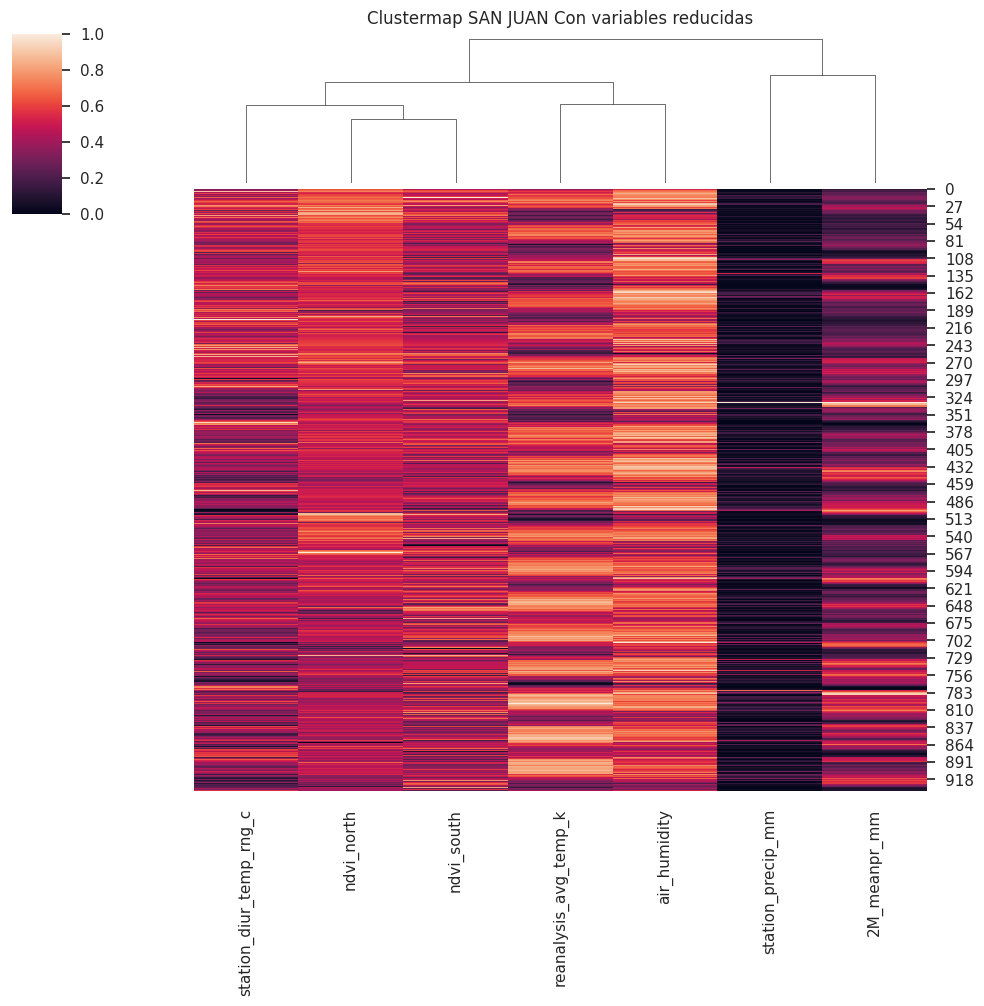

In [126]:
# Clustermap SAN JUAN Con variables reducidas

sbrn.set(color_codes = True)
clus_map = sbrn.clustermap(red_sj_numval, standard_scale=1, row_cluster=False)
clus_map.ax_col_dendrogram.set_title('Clustermap SAN JUAN Con variables reducidas') 

Text(0.5, 1.0, 'Clustermap IQUITOS Con variables reducidas')

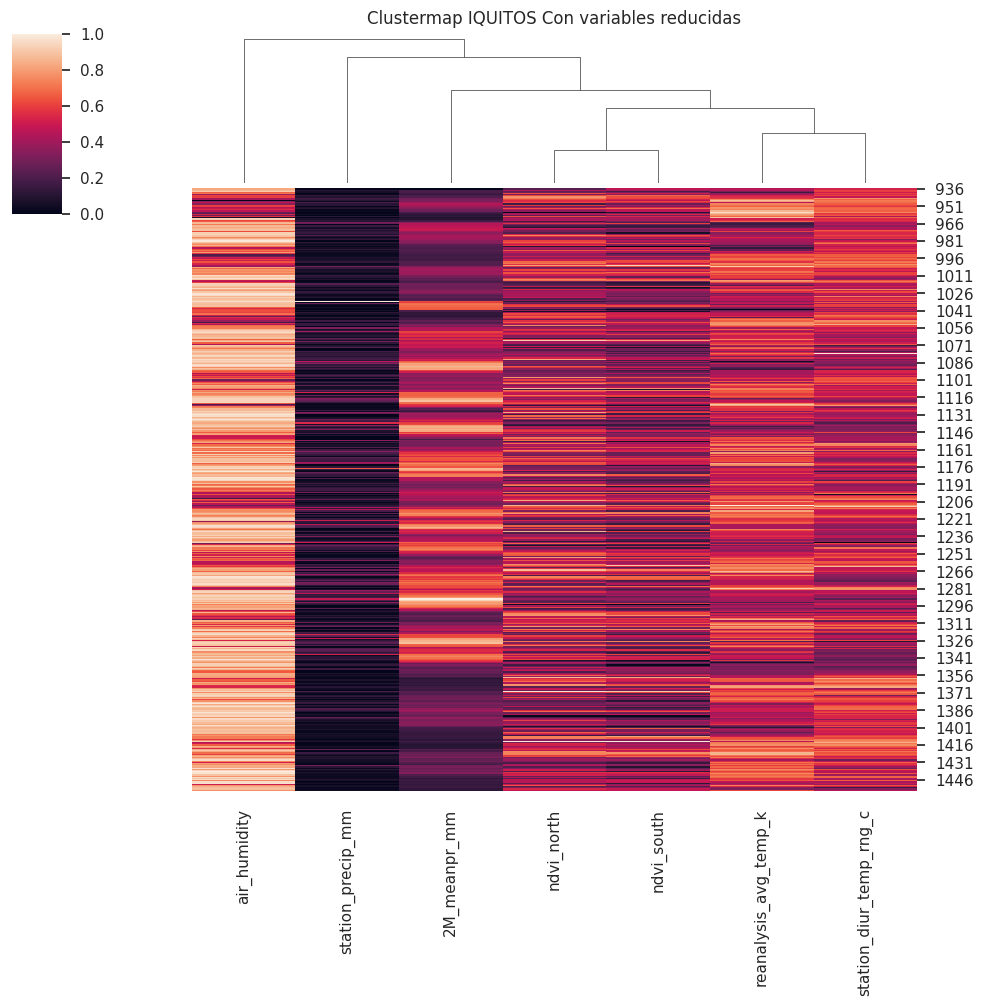

In [128]:
# Clustermap IQUITOS Con variables reducidas

sbrn.set(color_codes = True)
clus_map = sbrn.clustermap(red_iq_numval, standard_scale=1, row_cluster=False)
clus_map.ax_col_dendrogram.set_title('Clustermap IQUITOS Con variables reducidas') 

In [112]:
sj_train.describe()

,reanalysis_avg_temp_k,station_diur_temp_rng_c,station_precip_mm,ndvi_north,ndvi_south,air_humidity,2M_meanpr_mm
count,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000
mean,299.270520,6.753892,26.778846,0.062180,0.171589,373.672415,26.810181
std,1.218688,0.835684,29.241411,0.087653,0.053676,4.590650,12.693722
min,296.114286,4.528571,0.000000,-0.312350,-0.009429,356.378571,2.400000
25%,298.291071,6.200000,6.900000,0.010874,0.136813,370.671786,17.756250
50%,299.378571,6.757143,17.800000,0.062167,0.171239,374.097857,24.912500
75%,300.223214,7.285714,35.525000,0.108846,0.204589,377.042500,35.489062
max,302.164286,9.914286,305.900000,0.422900,0.380529,384.407143,77.600000


In [ ]:
# Selección de métodos de normalización basados en las variables, recuparado de: https://erdem.pl/2020/08/deng-ai-data-preprocessing

"""
reanalysis_avg_temp_k = StandardScaler
station_diur_temp_rng_c = MinMaxScaler
station_precip_mm = MinMaxScaler
ndvi_north = Mantiene valor
ndvi_south = Mantiene valor
air_humidity = StandardScaler
2M_meanpr_mm = MinMaxScaler
"""

Dependiendo del tipo de dato y rangos de cada una de las variables, se determina que tipo de normalización se va a aplicar sobre la misma en la función de procesamiento de sets de datos.

In [147]:
# Subir de nuevo el conjunto de entrenamiento sin variable objetivo (dengue_features_train.csv)

train_data = upload_files()
print(train_data.shape)

Saving dengue_features_train.csv to dengue_features_train (4).csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes
(1456, 24)


In [130]:
# Definición de función que toma datos de (dengue_features_train.csv) y realiza las operaciones necesarias para obtener características selecionadas y normalizadas:

def dengAI_data_preprocessing (df, normalize = True):

  standard_scaler = StandardScaler()
  minmax_scaler = MinMaxScaler()

  # Interpolación linear de los datos faltantes:
  df.interpolate(method="linear", inplace=True)

  # Transformación de variable "week_start_date" de string a datetime:
  df['week_start_date'] = df['week_start_date'].str.replace("-", "")
  df['week_start_date'] = pd.to_datetime(df['week_start_date'], format='%Y%m%d')

  # Borrado de variables "year" y "week_of_year":
  df.drop(["year", "weekofyear"], axis = 1, inplace = True)

  # Borrado de variables con correlación igual al 100%:
  df.drop(["precipitation_amt_mm", "reanalysis_specific_humidity_g_per_kg"], axis = 1, inplace = True)

  # Creación de nuavas variables de precipitación y humedad:
  df["air_humidity"] = df["reanalysis_dew_point_temp_k"] + df["reanalysis_relative_humidity_percent"]
  df["2M_meanpr_mm"] = df["station_precip_mm"].rolling(8, min_periods = 1).mean()

  # Promedio de valores norte y sur en variables de nivel de vegetación:
  df["ndvi_north"] = (df["ndvi_ne"] + df["ndvi_nw"])/2
  df["ndvi_south"] = (df["ndvi_se"] + df["ndvi_sw"])/2
  

  # Borrado de variables redundantes:
  df.drop(["reanalysis_sat_precip_amt_mm", "reanalysis_precip_amt_kg_per_m2"], axis = 1, inplace = True)
  df.drop(["reanalysis_dew_point_temp_k", "reanalysis_relative_humidity_percent"], axis = 1, inplace = True)
  df.drop(["ndvi_ne", "ndvi_nw", "ndvi_se", "ndvi_sw"], axis = 1, inplace = True)
  df.drop(["reanalysis_air_temp_k", "reanalysis_max_air_temp_k", "reanalysis_min_air_temp_k", "reanalysis_tdtr_k",	"station_avg_temp_c", "station_max_temp_c", "station_min_temp_c"], axis = 1, inplace = True)

  # Normalizado de variables dependiendo del tipo de datos:
  if normalize == True:
    df[['reanalysis_avg_temp_k','air_humidity']] = standard_scaler.fit_transform(df[['reanalysis_avg_temp_k','air_humidity']])
    df[['station_diur_temp_rng_c','station_precip_mm', '2M_meanpr_mm']] = minmax_scaler.fit_transform(df[['station_diur_temp_rng_c','station_precip_mm', '2M_meanpr_mm']])

  return df

Con el objetivo de trasladar los resultados obteneidos en esta actividad a la actividad número 2, se genera una función que realiza todas las transformaciones necesarias al dataframe seleccionado y arroja un nuevo dataframe con la lista final de caracteristicas utilizadas para los primeros experimentos de la actividad número 2.

In [149]:
group = train_data.groupby(train_data.city)
sj_data = group.get_group("sj")
iq_data = group.get_group("iq")

print("SJ trainData: ", sj_data.shape, "IQ trainData: ", iq_data.shape)

SJ trainData:  (936, 24) IQ trainData:  (520, 24)


In [150]:
sj_sample_df = dengAI_data_preprocessing(sj_data, normalize=True)
iq_sample_df = dengAI_data_preprocessing(iq_data, normalize=True)

In [152]:
print("SJ: ", sj_sample_df.shape)
print("IQ: ", iq_sample_df.shape)

SJ:  (936, 9)
IQ:  (520, 9)


---
# Conclusiones
---

**Resultados de la experimentación**:
* Lista de características: 

  * city
  * week_start_date
  * reanalysis_avg_temp_k
  * station_diur_tamp_rng_c 
  * station_precip_mm 
  * 2M_meanpr_mm 
  * ndvi_north 
  * ndvi_south
  * air_humidity

* Resumen dataset (transformaciones, etc.):

Lista de transformaciones sobre los datos, cuyo proceso se puede evidenciar de mejor manera revisando la función "dengAI_data_preprocessing":

1. Interpolación linear de los datos faltantes.
2. Transformación de variable "week_start_date" de string a datetime.
3. Borrado de variables "year" y "week_of_year".
4. Borrado de variables con correlación igual al 100%
5. Creación de nuavas variables de precipitación y humedad.
6. Promedio de valores norte y sur en variables de nivel de vegetación.
7. Borrado de variables redundantes.
8. Normalizado de variables dependiendo del tipo de datos.

Tras aplicar estas transformaciones y dividir los sets de datos entre ciudades se obtienen dos datasets con las 8 caracteristicas presentes en la lista mencionada anteriormente.

Se considera que la lista final de variables seleccionadas cumple con realizar una descripción de todos los tipos de datos mencionados durante la actividad, ya que hay variables relacionadas con: Tiempo, temperatura, humedad, vegetación y precipitaciones.

Con esta lista de variables se logra resumir el número de datos para entrenamiento sin perder una gran cantidad de información y también se generan variables nuevas ya sea combinando o aplicando transformaciones y promedios sobre variables que ya había presentes en el set de datos.

Para la actividad número 2 es importante tener en cuenta que la selección y filtrado de variables no se hizo teniendo en cuanta cuales tienen mayor correlación con la variable objetivo. Por lo tanto podría haber cambios en cuanto a las variables especificas que se conservan o descartan para esa actividad.

Mejoras y trabajo futuro:

* Realizar clusterización con otras funciones como DBSCAN
* Posibibidad de generar otros promedios similares al implementado en precipitaciones
* Combinación de variables a partir de los crupos generados en los clustermap